In [1]:

import torch, random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from pathlib import Path
import numpy as np
# ---------
# torch.set_grad_enabled(False)
# ============================
#       Radom Seed
# ============================
seed = 99

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    print(f"cuda:True")
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")
else:
    print(f"cuda:False")
    device = torch.device("cpu")


# ============================
#       Equilibrium CNN
# ============================
def linear(x):
    # return F.hardsigmoid(x)
    return x
def hardtanh6(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = -6, max=6)
def hardtanh6_d(x):
        return ((x > -6) & (x < 6)).float()
def hardtanh(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = -1, max=1)
def hardtanh_d(x):
        return ((x > -1) & (x < 1)).float()
def hardsigm(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = 0, max=1)
def hardsigm_d(x):
        return ((x > 0) & (x < 1)).float()
def relu6(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = 0, max=6)
def relu6_d(x):
        return ((x > 0) & (x < 6)).float()
def relu(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = 0)
def relu_d(x):
        return ((x > 0)).float()

cuda:True
GPU 0:NVIDIA RTX A5000:23.99GB


In [2]:

fsave=True
current_time_start = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_path = Path(f"./Res/Final_conv_{current_time_start}-CIFAR10")
res_path.mkdir(parents=True, exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (3*0.2023, 3*0.1994, 3*0.2010))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset = Subset(train_set, range(int(1 * len(train_set))))
test_subset = Subset(test_set, range(int(1 * len(test_set))))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=512, shuffle=False)

print(torch.cuda.is_available())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

criterion = nn.CrossEntropyLoss()

num_epochs = 40
multest =1 #5
fbsc_range = [0] # 0.01, 0.1, 1
res = np.zeros((len(fbsc_range),multest,3,num_epochs))





Files already downloaded and verified
Files already downloaded and verified
True
GPU 0:NVIDIA RTX A5000:23.99GB


### Network conv

In [3]:


class aEP_CNN(nn.Module):
    def __init__(self, fbsc=0.1, nudge= 0.2, deviden=True, T=60, K=20, chl= [32, 64, 128]):
        super().__init__()

        self.T = T
        self.K = K
        self.eta = 1 # leaky rate
        self.ffSC, self.fbSC, self.nudge = 1.0, fbsc, nudge
        self.deviden = deviden
        self.chl = chl
        self.rho = hardsigm # hardsigm relu6 relu6 hardtanh hardtanh6 linear

        self.conv1 = nn.Conv2d(3, self.chl[0], kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride = 2, return_indices = True)  
        self.conv2 = nn.Conv2d(self.chl[0], self.chl[1], kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride = 2, return_indices = True)  
        
        self.conv3 = nn.Conv2d(self.chl[1], self.chl[2], kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, stride = 2, return_indices = True)  

        self.fc1 = nn.Linear(self.chl[2] * 4 * 4, 10)

        self.unpool1 = nn.MaxUnpool2d(2, stride = 2)  
        self.unpool2 = nn.MaxUnpool2d(2, stride = 2)  
        self.unpool3 = nn.MaxUnpool2d(2, stride = 2)  

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    @torch.no_grad()
    def forward(self, x, t=0, s=0, nudge = 0, target=None):
        if t>0:
            x1, p1, ind1, x2, p2, ind2, x3, p3, ind3, fc1 = s  
        else:
            # x1, p1, ind1, x2, p2, ind2, x3 = 0, 0, 0, 0, 0, 0, 0
            x1 = self.conv1(torch.zeros_like(x,device=self.device))       # torch.zeros_like(x,device=self.device)
            p1, ind1 = self.pool1(self.rho(x1))
            x2 = self.conv2(p1)      # (B, 32, 16, 16)
            p2, ind2 = self.pool2(self.rho(x2))
            x3 = self.conv3(p2)      # (B, 32, 16, 16)
            p3, ind3 = self.pool3(self.rho(x3))

            fc1 = ( self.fc1(p3.view(p3.size(0), -1)))
        
        # if nudge!=0:
        if nudge!=0: 
            fb =  (target-F.softmax(fc1,dim=1)) @ self.fc1.weight 
            fbs = fb.view(fb.size(0), self.chl[2], 4, 4)
        else:
            fbs = torch.zeros_like(p3,device=self.device)
        # else:
        #     fbs = torch.zeros_like(p2,device=self.device) F.conv_transpose2d(delta_conv4, self.conv2.weight, stride=1, padding=1) #.permute([0,1,3,2])
        p1, ind1 = self.pool1(self.rho(x1))       # output_size =(B, 128, 16, 16)
        p2, ind2 = self.pool2(self.rho(x2))      # (B, 256, 8, 8)
        p3, ind3 = self.pool3(self.rho(x3))      # (B, 512, 4, 4)
        
        dx1 =  (self.conv1(x)*self.ffSC +self.unpool1( F.conv_transpose2d(self.rho(x2), self.conv2.weight, stride=1, padding=1),
                                            ind1,output_size=x1.shape)*self.fbSC)
        
        dx2 =  (self.conv2(p1)*self.ffSC + self.unpool2(F.conv_transpose2d(self.rho(x3), self.conv3.weight, stride=1, padding=1),
                                                        ind2,output_size=x2.shape)*self.fbSC)

        dx3 =  (self.conv3(p2)*self.ffSC + self.unpool3(fbs,ind3,output_size=x3.shape)* nudge )

        dfc = ( self.fc1(p3.view(p3.size(0), -1)))

        x1 =dx1
        x2 =dx2
        x3 =dx3
        fc1 = dfc
        # if nudge == 0: fc1 = dfc
        return x1, p1, ind1, x2, p2, ind2, x3, p3, ind3, fc1
    
    
    @torch.no_grad()
    def ep_step(self, x, y):
        x = x.to(self.device)
        y = y.to(self.device)
        y_onehot = F.one_hot(y, num_classes=10).float().to(self.device)

        # Free phase dynamics
        sf = 0
        
        # self.deconv2.bias.data = self.conv2.bias.clone()
        for t in range(self.T):
            sf = self.forward(x, t=t, s=sf, nudge=0, target=y_onehot)

        x1, p1, _, x2, p2, _, x3, p3, _, fc1 = sf
        # self.x1, self.x2, self.x3, self.xfc1 = x1, x2, x3, fc1
        preds = torch.argmax(sf[-1], dim=1)

        # Nudged phase dynamics
        sn = [t.clone() for t in sf]
        for t in range(self.K):
            sn = self.forward(x, t=self.T+t, s=sn, nudge=self.nudge, target=y_onehot)

        # Weight update: contrastive Hebbian rule (difference of activations)
        
        x1n, _, _, x2n, _, _, x3n, _, _, fc1n = sn

        # after free-phase we had: x1,x2,x3,x4 and p1,p2,p3,p4 and fc1 (free)
        # after nudged-phase sn we get x1n,...,x4n and p4n and fc1_nudged (sn[-1])
        beta = self.nudge if self.deviden else 1#
        
        # fc
        # delta_fc = (F.softmax(fc1, dim=1) - F.softmax(fc1n, dim=1)) / (beta * x.size(0))
        delta_fc = (F.softmax(fc1, dim=1) - y_onehot) / (x.size(0))
        flatp4 = p3.view(p3.size(0), -1).contiguous()
        self.fc1.weight.grad = delta_fc.T @ flatp4
        self.fc1.bias.grad = delta_fc.sum(0)


        # conv3
        delta_conv3 = ((self.rho(x3) - self.rho(x3n)) / ( self.fbSC**0 * beta * x.size(0))).contiguous()
        grad_conv3_w = torch.nn.grad.conv2d_weight(p2.contiguous(), self.conv3.weight.shape, delta_conv3, stride=1, padding=1)
        self.conv3.weight.grad = grad_conv3_w
        self.conv3.bias.grad = delta_conv3.sum(dim=(0,2,3))

        # conv2
        delta_conv2 = ((self.rho(x2) - self.rho(x2n)) / ( self.fbSC**0 * beta * x.size(0))).contiguous()
        grad_conv2_w = torch.nn.grad.conv2d_weight(p1.contiguous(), self.conv2.weight.shape, delta_conv2, stride=1, padding=1)
        self.conv2.weight.grad = grad_conv2_w
        self.conv2.bias.grad = delta_conv2.sum(dim=(0,2,3))

        # conv1
        delta_conv1 = ((self.rho(x1) - self.rho(x1n)) / ( self.fbSC**0 * beta * x.size(0))).contiguous()
        grad_conv1_w = torch.nn.grad.conv2d_weight(x.contiguous(), self.conv1.weight.shape, delta_conv1, stride=1, padding=1)
        self.conv1.weight.grad = grad_conv1_w
        self.conv1.bias.grad = delta_conv1.sum(dim=(0,2,3))

        
        # self.dx1, self.dx2, self.dx3, self.dx4, self.dxfc1 = (self.rho(x1) - self.rho(x1n)), (self.rho(x2) - self.rho(x2n)), (self.rho(x3) - self.rho(x3n)), (self.rho(x4) - self.rho(x4n)), (F.softmax(fc1, dim=1) - F.softmax(fc1n, dim=1))

        return preds, F.cross_entropy(fc1, y).item()
    

    # @torch.no_grad()
    # def bw_symm(self):
    #     self.deconv2.weight.data = self.conv2.weight.data.clone()
    #     return
    
    @torch.no_grad()
    def predict(self, x):
        with torch.no_grad():
            x = x.to(self.device)
            sf = 0
            
            for t in range(self.T):
                sf = self.forward(x, t=t, s=sf, nudge=0, target=None)

            preds = torch.argmax(sf[-1], dim=1)
        return preds
    
    def forward_BP(self, x):
        # return pre-activations(z) and post-activations(x) and pooled results
        # z* = pre-activation (conv output), x* = post-activation = rho(z*)
        z1 = self.conv1(x)
        x1 = self.rho(z1)
        p1, ind1 = self.pool1(x1)

        z2 = self.conv2(p1)
        x2 = self.rho(z2)
        p2, ind2 = self.pool2(x2)

        z3 = self.conv3(p2)
        x3 = self.rho(z3)
        p3, ind3 = self.pool3(x3)

        # fix: use p4.size(0) (batch dim of p4) for view
        fc1 = self.fc1(p3.view(p3.size(0), -1))

        #  post, pools, inds, logits
        
        # self.x1, self.x2, self.x3, self.xfc1 = x1, x2, x3, fc1
        return z1, x1, p1, ind1, z2, x2, p2, ind2, z3, x3, p3, ind3, fc1


### BP

In [4]:

num_epochs = 50
multest = 5 #5
fbsc_range = [0] # 0.01, 0.1, 1
res = np.zeros((len(fbsc_range),multest,3,num_epochs))
for ifbsc in range(len(fbsc_range)):
    for imul in range(multest):
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{imul} start at {current_time_tmp}")
        model = aEP_CNN( chl=[32,64,128])

        optimizer = torch.optim.AdamW(model.parameters(), lr=2.5e-4, weight_decay=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 
                                         T_max=num_epochs,  
                                         eta_min=1e-6) 

        for epoch in range(num_epochs):
            total_loss = 0
            correct = 0
            total = 0

            random.shuffle(train_loader_gpu)
            with tqdm(total=len(train_loader_gpu), desc=f"Epoch {epoch + 1}/{num_epochs}:", unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                for batch_idx, (data, target) in enumerate(train_loader_gpu):
                    optimizer.zero_grad()
                    preds = model.forward_BP(data)# eta=[0.015, 0.035, 0.15]
                    loss = criterion(preds[-1], target)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss

                    if batch_idx % 10 == 0: 
                        pbar.set_postfix({'loss': f'{total_loss/(batch_idx+1):.6f}'})  
                        pbar.update(10)

                    correct += (torch.argmax(preds[-1], dim=1) == target).sum().item()
                    total += target.size(0)
                    
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}, Current LR: {current_lr:.2e}")

            acc = correct / total
            avg_loss = total_loss / len(train_loader_gpu)
            res[ifbsc,imul,0,epoch]=(avg_loss)
            res[ifbsc,imul,1,epoch]=(acc)

            # Test
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader_gpu:
                    preds = model.forward_BP(data)
                    correct += (torch.argmax(preds[-1], dim=1) == target).sum().item()
                    total += target.size(0)
            test_acc = correct / total
            res[ifbsc,imul,2,epoch]=(test_acc)

            print(f"Epoch {epoch+1} Train Loss = {avg_loss:.4f}, Accuracy = {acc*100:.2f}%, Test Accuracy = {test_acc*100:.2f}%")
        
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{imul} end at {current_time_tmp}")
        
res_BP = res
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if fsave: 
    save_dict = {
        "res": res
}
np.savez_compressed(res_path / f"res_BP",  **save_dict)
     

0 start at 20250924-163648


Epoch 1/50:: 400batch [00:03, 121.45batch/s, loss=1.701606]                               1.701606]


Epoch 1, Current LR: 2.50e-04
Epoch 1 Train Loss = 1.7016, Accuracy = 39.32%, Test Accuracy = 48.65%


Epoch 2/50:: 400batch [00:02, 193.79batch/s, loss=1.363052]                               1.363052]


Epoch 2, Current LR: 2.49e-04
Epoch 2 Train Loss = 1.3631, Accuracy = 51.61%, Test Accuracy = 54.37%


Epoch 3/50:: 400batch [00:02, 192.18batch/s, loss=1.243485]                               1.243485]


Epoch 3, Current LR: 2.48e-04
Epoch 3 Train Loss = 1.2435, Accuracy = 56.30%, Test Accuracy = 58.05%


Epoch 4/50:: 400batch [00:02, 177.66batch/s, loss=1.150283]                               1.150283]


Epoch 4, Current LR: 2.46e-04
Epoch 4 Train Loss = 1.1503, Accuracy = 59.82%, Test Accuracy = 60.75%


Epoch 5/50:: 400batch [00:02, 185.81batch/s, loss=1.076913]                               1.076913]


Epoch 5, Current LR: 2.44e-04
Epoch 5 Train Loss = 1.0769, Accuracy = 62.63%, Test Accuracy = 62.29%


Epoch 6/50:: 400batch [00:02, 176.37batch/s, loss=1.017625]                               1.017625]


Epoch 6, Current LR: 2.41e-04
Epoch 6 Train Loss = 1.0176, Accuracy = 64.48%, Test Accuracy = 63.14%


Epoch 7/50:: 400batch [00:02, 175.98batch/s, loss=0.968508]                               0.968508]


Epoch 7, Current LR: 2.38e-04
Epoch 7 Train Loss = 0.9685, Accuracy = 66.29%, Test Accuracy = 65.99%


Epoch 8/50:: 400batch [00:02, 176.36batch/s, loss=0.924126]                               0.924126]


Epoch 8, Current LR: 2.35e-04
Epoch 8 Train Loss = 0.9241, Accuracy = 68.11%, Test Accuracy = 66.58%


Epoch 9/50:: 400batch [00:02, 188.32batch/s, loss=0.887492]                               0.887492]


Epoch 9, Current LR: 2.31e-04
Epoch 9 Train Loss = 0.8875, Accuracy = 69.34%, Test Accuracy = 67.98%


Epoch 10/50:: 400batch [00:02, 177.76batch/s, loss=0.855365]                              0.855365]


Epoch 10, Current LR: 2.26e-04
Epoch 10 Train Loss = 0.8554, Accuracy = 70.64%, Test Accuracy = 69.28%


Epoch 11/50:: 400batch [00:02, 189.56batch/s, loss=0.830619]                              0.830619]


Epoch 11, Current LR: 2.21e-04
Epoch 11 Train Loss = 0.8306, Accuracy = 71.45%, Test Accuracy = 69.27%


Epoch 12/50:: 400batch [00:02, 198.42batch/s, loss=0.802792]                              0.802792]


Epoch 12, Current LR: 2.16e-04
Epoch 12 Train Loss = 0.8028, Accuracy = 72.43%, Test Accuracy = 69.76%


Epoch 13/50:: 400batch [00:01, 235.58batch/s, loss=0.782855]                              0.782855]


Epoch 13, Current LR: 2.11e-04
Epoch 13 Train Loss = 0.7829, Accuracy = 73.05%, Test Accuracy = 71.14%


Epoch 14/50:: 400batch [00:02, 183.94batch/s, loss=0.760192]                              0.760192]


Epoch 14, Current LR: 2.05e-04
Epoch 14 Train Loss = 0.7602, Accuracy = 73.91%, Test Accuracy = 71.55%


Epoch 15/50:: 400batch [00:02, 195.43batch/s, loss=0.744585]                              0.744585]


Epoch 15, Current LR: 1.99e-04
Epoch 15 Train Loss = 0.7446, Accuracy = 74.68%, Test Accuracy = 71.59%


Epoch 16/50:: 400batch [00:02, 168.70batch/s, loss=0.724096]                              0.724096]


Epoch 16, Current LR: 1.92e-04
Epoch 16 Train Loss = 0.7241, Accuracy = 75.24%, Test Accuracy = 71.83%


Epoch 17/50:: 400batch [00:02, 182.76batch/s, loss=0.709278]                              0.709278]


Epoch 17, Current LR: 1.85e-04
Epoch 17 Train Loss = 0.7093, Accuracy = 75.68%, Test Accuracy = 71.65%


Epoch 18/50:: 400batch [00:01, 204.99batch/s, loss=0.693544]                              0.693544]


Epoch 18, Current LR: 1.79e-04
Epoch 18 Train Loss = 0.6935, Accuracy = 76.18%, Test Accuracy = 72.08%


Epoch 19/50:: 400batch [00:02, 186.86batch/s, loss=0.679734]                              0.679734]


Epoch 19, Current LR: 1.71e-04
Epoch 19 Train Loss = 0.6797, Accuracy = 76.88%, Test Accuracy = 73.47%


Epoch 20/50:: 400batch [00:02, 195.57batch/s, loss=0.668227]                              0.668227]


Epoch 20, Current LR: 1.64e-04
Epoch 20 Train Loss = 0.6682, Accuracy = 77.43%, Test Accuracy = 73.17%


Epoch 21/50:: 400batch [00:01, 207.45batch/s, loss=0.654602]                              0.654602]


Epoch 21, Current LR: 1.56e-04
Epoch 21 Train Loss = 0.6546, Accuracy = 77.88%, Test Accuracy = 73.02%


Epoch 22/50:: 400batch [00:02, 198.86batch/s, loss=0.644035]                              0.644035]


Epoch 22, Current LR: 1.49e-04
Epoch 22 Train Loss = 0.6440, Accuracy = 78.30%, Test Accuracy = 73.52%


Epoch 23/50:: 400batch [00:02, 185.05batch/s, loss=0.632841]                              0.632841]


Epoch 23, Current LR: 1.41e-04
Epoch 23 Train Loss = 0.6328, Accuracy = 78.57%, Test Accuracy = 73.42%


Epoch 24/50:: 400batch [00:01, 217.84batch/s, loss=0.620457]                              0.620457]


Epoch 24, Current LR: 1.33e-04
Epoch 24 Train Loss = 0.6205, Accuracy = 79.21%, Test Accuracy = 73.97%


Epoch 25/50:: 400batch [00:01, 214.72batch/s, loss=0.612170]                              0.612170]


Epoch 25, Current LR: 1.25e-04
Epoch 25 Train Loss = 0.6122, Accuracy = 79.45%, Test Accuracy = 74.16%


Epoch 26/50:: 400batch [00:02, 198.30batch/s, loss=0.602726]                              0.602726]


Epoch 26, Current LR: 1.18e-04
Epoch 26 Train Loss = 0.6027, Accuracy = 79.69%, Test Accuracy = 73.96%


Epoch 27/50:: 400batch [00:01, 219.21batch/s, loss=0.592995]                              0.592995]


Epoch 27, Current LR: 1.10e-04
Epoch 27 Train Loss = 0.5930, Accuracy = 80.19%, Test Accuracy = 74.39%


Epoch 28/50:: 400batch [00:01, 209.90batch/s, loss=0.585232]                              0.585232]


Epoch 28, Current LR: 1.02e-04
Epoch 28 Train Loss = 0.5852, Accuracy = 80.53%, Test Accuracy = 74.43%


Epoch 29/50:: 400batch [00:01, 201.59batch/s, loss=0.577915]                              0.577915]


Epoch 29, Current LR: 9.45e-05
Epoch 29 Train Loss = 0.5779, Accuracy = 80.72%, Test Accuracy = 74.55%


Epoch 30/50:: 400batch [00:01, 209.03batch/s, loss=0.571567]                              0.571567]


Epoch 30, Current LR: 8.70e-05
Epoch 30 Train Loss = 0.5716, Accuracy = 81.02%, Test Accuracy = 74.58%


Epoch 31/50:: 400batch [00:02, 166.26batch/s, loss=0.563523]                              0.563523]


Epoch 31, Current LR: 7.97e-05
Epoch 31 Train Loss = 0.5635, Accuracy = 81.31%, Test Accuracy = 74.59%


Epoch 32/50:: 400batch [00:02, 193.93batch/s, loss=0.557851]                              0.557851]


Epoch 32, Current LR: 7.25e-05
Epoch 32 Train Loss = 0.5579, Accuracy = 81.49%, Test Accuracy = 74.54%


Epoch 33/50:: 400batch [00:02, 167.87batch/s, loss=0.552883]                              0.552883]


Epoch 33, Current LR: 6.55e-05
Epoch 33 Train Loss = 0.5529, Accuracy = 81.72%, Test Accuracy = 74.69%


Epoch 34/50:: 400batch [00:02, 157.64batch/s, loss=0.547688]                              0.547688]


Epoch 34, Current LR: 5.88e-05
Epoch 34 Train Loss = 0.5477, Accuracy = 81.91%, Test Accuracy = 74.72%


Epoch 35/50:: 400batch [00:02, 148.18batch/s, loss=0.542586]                              0.542586]


Epoch 35, Current LR: 5.23e-05
Epoch 35 Train Loss = 0.5426, Accuracy = 82.12%, Test Accuracy = 74.82%


Epoch 36/50:: 400batch [00:02, 164.68batch/s, loss=0.537735]                              0.537735]


Epoch 36, Current LR: 4.61e-05
Epoch 36 Train Loss = 0.5377, Accuracy = 82.25%, Test Accuracy = 75.25%


Epoch 37/50:: 400batch [00:02, 178.33batch/s, loss=0.534037]                              0.534037]


Epoch 37, Current LR: 4.03e-05
Epoch 37 Train Loss = 0.5340, Accuracy = 82.43%, Test Accuracy = 74.87%


Epoch 38/50:: 400batch [00:02, 171.83batch/s, loss=0.530500]                              0.530500]


Epoch 38, Current LR: 3.47e-05
Epoch 38 Train Loss = 0.5305, Accuracy = 82.55%, Test Accuracy = 75.07%


Epoch 39/50:: 400batch [00:02, 172.40batch/s, loss=0.527416]                              0.527416]


Epoch 39, Current LR: 2.96e-05
Epoch 39 Train Loss = 0.5274, Accuracy = 82.79%, Test Accuracy = 75.32%


Epoch 40/50:: 400batch [00:02, 178.14batch/s, loss=0.524839]                              0.524839]


Epoch 40, Current LR: 2.48e-05
Epoch 40 Train Loss = 0.5248, Accuracy = 82.94%, Test Accuracy = 75.26%


Epoch 41/50:: 400batch [00:01, 200.11batch/s, loss=0.521453]                              0.521453]


Epoch 41, Current LR: 2.04e-05
Epoch 41 Train Loss = 0.5215, Accuracy = 82.96%, Test Accuracy = 75.05%


Epoch 42/50:: 400batch [00:02, 150.52batch/s, loss=0.519207]                              0.519207]


Epoch 42, Current LR: 1.64e-05
Epoch 42 Train Loss = 0.5192, Accuracy = 83.07%, Test Accuracy = 75.09%


Epoch 43/50:: 400batch [00:02, 169.66batch/s, loss=0.517458]                              0.517458]


Epoch 43, Current LR: 1.28e-05
Epoch 43 Train Loss = 0.5175, Accuracy = 83.22%, Test Accuracy = 75.15%


Epoch 44/50:: 400batch [00:02, 186.77batch/s, loss=0.515951]                              0.515951]


Epoch 44, Current LR: 9.74e-06
Epoch 44 Train Loss = 0.5160, Accuracy = 83.25%, Test Accuracy = 75.25%


Epoch 45/50:: 400batch [00:02, 196.90batch/s, loss=0.514637]                              0.514637]


Epoch 45, Current LR: 7.09e-06
Epoch 45 Train Loss = 0.5146, Accuracy = 83.33%, Test Accuracy = 75.19%


Epoch 46/50:: 400batch [00:02, 170.67batch/s, loss=0.513663]                              0.513663]


Epoch 46, Current LR: 4.91e-06
Epoch 46 Train Loss = 0.5137, Accuracy = 83.31%, Test Accuracy = 75.22%


Epoch 47/50:: 400batch [00:01, 215.13batch/s, loss=0.512576]                              0.512576]


Epoch 47, Current LR: 3.21e-06
Epoch 47 Train Loss = 0.5126, Accuracy = 83.42%, Test Accuracy = 75.30%


Epoch 48/50:: 400batch [00:02, 171.32batch/s, loss=0.512046]                              0.512046]


Epoch 48, Current LR: 1.98e-06
Epoch 48 Train Loss = 0.5120, Accuracy = 83.45%, Test Accuracy = 75.35%


Epoch 49/50:: 400batch [00:02, 145.53batch/s, loss=0.511556]                              0.511556]


Epoch 49, Current LR: 1.25e-06
Epoch 49 Train Loss = 0.5116, Accuracy = 83.43%, Test Accuracy = 75.33%


Epoch 50/50:: 400batch [00:02, 149.06batch/s, loss=0.511327]                              0.511327]


Epoch 50, Current LR: 1.00e-06
Epoch 50 Train Loss = 0.5113, Accuracy = 83.52%, Test Accuracy = 75.27%
0 end at 20250924-163840
1 start at 20250924-163840


Epoch 1/50:: 400batch [00:02, 156.60batch/s, loss=1.703343]                               1.703343]


Epoch 1, Current LR: 2.50e-04
Epoch 1 Train Loss = 1.7033, Accuracy = 38.31%, Test Accuracy = 47.02%


Epoch 2/50:: 400batch [00:02, 172.99batch/s, loss=1.372543]                               1.372543]


Epoch 2, Current LR: 2.49e-04
Epoch 2 Train Loss = 1.3725, Accuracy = 50.52%, Test Accuracy = 52.84%


Epoch 3/50:: 400batch [00:02, 144.90batch/s, loss=1.257552]                               1.257552]


Epoch 3, Current LR: 2.48e-04
Epoch 3 Train Loss = 1.2576, Accuracy = 55.41%, Test Accuracy = 56.68%


Epoch 4/50:: 400batch [00:02, 180.57batch/s, loss=1.177598]                               1.177598]


Epoch 4, Current LR: 2.46e-04
Epoch 4 Train Loss = 1.1776, Accuracy = 58.56%, Test Accuracy = 59.62%


Epoch 5/50:: 400batch [00:02, 169.71batch/s, loss=1.109526]                               1.109526]


Epoch 5, Current LR: 2.44e-04
Epoch 5 Train Loss = 1.1095, Accuracy = 61.09%, Test Accuracy = 62.02%


Epoch 6/50:: 400batch [00:02, 166.22batch/s, loss=1.054341]                               1.054341]


Epoch 6, Current LR: 2.41e-04
Epoch 6 Train Loss = 1.0543, Accuracy = 63.34%, Test Accuracy = 63.78%


Epoch 7/50:: 400batch [00:02, 187.85batch/s, loss=1.004514]                               1.004514]


Epoch 7, Current LR: 2.38e-04
Epoch 7 Train Loss = 1.0045, Accuracy = 65.30%, Test Accuracy = 65.18%


Epoch 8/50:: 400batch [00:02, 176.86batch/s, loss=0.959664]                               0.959664]


Epoch 8, Current LR: 2.35e-04
Epoch 8 Train Loss = 0.9597, Accuracy = 66.91%, Test Accuracy = 66.68%


Epoch 9/50:: 400batch [00:01, 212.04batch/s, loss=0.924521]                               0.924521]


Epoch 9, Current LR: 2.31e-04
Epoch 9 Train Loss = 0.9245, Accuracy = 68.22%, Test Accuracy = 67.06%


Epoch 10/50:: 400batch [00:02, 157.27batch/s, loss=0.888257]                              0.888257]


Epoch 10, Current LR: 2.26e-04
Epoch 10 Train Loss = 0.8883, Accuracy = 69.43%, Test Accuracy = 67.83%


Epoch 11/50:: 400batch [00:02, 164.31batch/s, loss=0.858481]                              0.858481]


Epoch 11, Current LR: 2.21e-04
Epoch 11 Train Loss = 0.8585, Accuracy = 70.71%, Test Accuracy = 68.68%


Epoch 12/50:: 400batch [00:02, 156.50batch/s, loss=0.833729]                              0.833729]


Epoch 12, Current LR: 2.16e-04
Epoch 12 Train Loss = 0.8337, Accuracy = 71.49%, Test Accuracy = 69.23%


Epoch 13/50:: 400batch [00:02, 176.57batch/s, loss=0.811485]                              0.811485]


Epoch 13, Current LR: 2.11e-04
Epoch 13 Train Loss = 0.8115, Accuracy = 72.20%, Test Accuracy = 69.51%


Epoch 14/50:: 400batch [00:02, 160.27batch/s, loss=0.786742]                              0.786742]


Epoch 14, Current LR: 2.05e-04
Epoch 14 Train Loss = 0.7867, Accuracy = 72.98%, Test Accuracy = 70.28%


Epoch 15/50:: 400batch [00:01, 206.84batch/s, loss=0.767249]                              0.767249]


Epoch 15, Current LR: 1.99e-04
Epoch 15 Train Loss = 0.7672, Accuracy = 73.84%, Test Accuracy = 71.15%


Epoch 16/50:: 400batch [00:02, 195.20batch/s, loss=0.750403]                              0.750403]


Epoch 16, Current LR: 1.92e-04
Epoch 16 Train Loss = 0.7504, Accuracy = 74.49%, Test Accuracy = 71.01%


Epoch 17/50:: 400batch [00:02, 175.55batch/s, loss=0.733393]                              0.733393]


Epoch 17, Current LR: 1.85e-04
Epoch 17 Train Loss = 0.7334, Accuracy = 75.10%, Test Accuracy = 72.06%


Epoch 18/50:: 400batch [00:01, 216.92batch/s, loss=0.715085]                              0.715085]


Epoch 18, Current LR: 1.79e-04
Epoch 18 Train Loss = 0.7151, Accuracy = 75.68%, Test Accuracy = 72.04%


Epoch 19/50:: 400batch [00:02, 171.91batch/s, loss=0.702106]                              0.702106]


Epoch 19, Current LR: 1.71e-04
Epoch 19 Train Loss = 0.7021, Accuracy = 76.22%, Test Accuracy = 72.21%


Epoch 20/50:: 400batch [00:01, 221.36batch/s, loss=0.687264]                              0.687264]


Epoch 20, Current LR: 1.64e-04
Epoch 20 Train Loss = 0.6873, Accuracy = 76.94%, Test Accuracy = 72.63%


Epoch 21/50:: 400batch [00:01, 221.70batch/s, loss=0.674088]                              0.674088]


Epoch 21, Current LR: 1.56e-04
Epoch 21 Train Loss = 0.6741, Accuracy = 77.38%, Test Accuracy = 73.11%


Epoch 22/50:: 400batch [00:01, 210.05batch/s, loss=0.661815]                              0.661815]


Epoch 22, Current LR: 1.49e-04
Epoch 22 Train Loss = 0.6618, Accuracy = 77.77%, Test Accuracy = 72.89%


Epoch 23/50:: 400batch [00:01, 201.83batch/s, loss=0.650859]                              0.650859]


Epoch 23, Current LR: 1.41e-04
Epoch 23 Train Loss = 0.6509, Accuracy = 78.30%, Test Accuracy = 73.12%


Epoch 24/50:: 400batch [00:01, 253.25batch/s, loss=0.638787]                              0.638787]


Epoch 24, Current LR: 1.33e-04
Epoch 24 Train Loss = 0.6388, Accuracy = 78.74%, Test Accuracy = 73.61%


Epoch 25/50:: 400batch [00:01, 200.36batch/s, loss=0.630052]                              0.630052]


Epoch 25, Current LR: 1.25e-04
Epoch 25 Train Loss = 0.6301, Accuracy = 78.89%, Test Accuracy = 73.73%


Epoch 26/50:: 400batch [00:01, 203.53batch/s, loss=0.619554]                              0.619554]


Epoch 26, Current LR: 1.18e-04
Epoch 26 Train Loss = 0.6196, Accuracy = 79.49%, Test Accuracy = 73.81%


Epoch 27/50:: 400batch [00:01, 252.11batch/s, loss=0.609867]                              0.609867]


Epoch 27, Current LR: 1.10e-04
Epoch 27 Train Loss = 0.6099, Accuracy = 79.82%, Test Accuracy = 73.01%


Epoch 28/50:: 400batch [00:01, 211.30batch/s, loss=0.602190]                              0.602190]


Epoch 28, Current LR: 1.02e-04
Epoch 28 Train Loss = 0.6022, Accuracy = 80.07%, Test Accuracy = 73.64%


Epoch 29/50:: 400batch [00:01, 239.84batch/s, loss=0.593687]                              0.593687]


Epoch 29, Current LR: 9.45e-05
Epoch 29 Train Loss = 0.5937, Accuracy = 80.44%, Test Accuracy = 74.25%


Epoch 30/50:: 400batch [00:02, 198.05batch/s, loss=0.586772]                              0.586772]


Epoch 30, Current LR: 8.70e-05
Epoch 30 Train Loss = 0.5868, Accuracy = 80.59%, Test Accuracy = 74.19%


Epoch 31/50:: 400batch [00:02, 197.32batch/s, loss=0.578956]                              0.578956]


Epoch 31, Current LR: 7.97e-05
Epoch 31 Train Loss = 0.5790, Accuracy = 80.84%, Test Accuracy = 74.17%


Epoch 32/50:: 400batch [00:01, 201.10batch/s, loss=0.573569]                              0.573569]


Epoch 32, Current LR: 7.25e-05
Epoch 32 Train Loss = 0.5736, Accuracy = 81.20%, Test Accuracy = 74.37%


Epoch 33/50:: 400batch [00:02, 162.13batch/s, loss=0.567728]                              0.567728]


Epoch 33, Current LR: 6.55e-05
Epoch 33 Train Loss = 0.5677, Accuracy = 81.54%, Test Accuracy = 74.26%


Epoch 34/50:: 400batch [00:01, 204.31batch/s, loss=0.562100]                              0.562100]


Epoch 34, Current LR: 5.88e-05
Epoch 34 Train Loss = 0.5621, Accuracy = 81.66%, Test Accuracy = 74.42%


Epoch 35/50:: 400batch [00:02, 187.62batch/s, loss=0.556993]                              0.556993]


Epoch 35, Current LR: 5.23e-05
Epoch 35 Train Loss = 0.5570, Accuracy = 81.77%, Test Accuracy = 74.62%


Epoch 36/50:: 400batch [00:01, 211.65batch/s, loss=0.552835]                              0.552835]


Epoch 36, Current LR: 4.61e-05
Epoch 36 Train Loss = 0.5528, Accuracy = 81.90%, Test Accuracy = 74.63%


Epoch 37/50:: 400batch [00:01, 222.24batch/s, loss=0.548945]                              0.548945]


Epoch 37, Current LR: 4.03e-05
Epoch 37 Train Loss = 0.5489, Accuracy = 82.10%, Test Accuracy = 74.38%


Epoch 38/50:: 400batch [00:02, 184.17batch/s, loss=0.545272]                              0.545272]


Epoch 38, Current LR: 3.47e-05
Epoch 38 Train Loss = 0.5453, Accuracy = 82.28%, Test Accuracy = 74.59%


Epoch 39/50:: 400batch [00:02, 188.63batch/s, loss=0.541879]                              0.541879]


Epoch 39, Current LR: 2.96e-05
Epoch 39 Train Loss = 0.5419, Accuracy = 82.36%, Test Accuracy = 74.58%


Epoch 40/50:: 400batch [00:01, 201.44batch/s, loss=0.538630]                              0.538630]


Epoch 40, Current LR: 2.48e-05
Epoch 40 Train Loss = 0.5386, Accuracy = 82.53%, Test Accuracy = 74.56%


Epoch 41/50:: 400batch [00:01, 218.71batch/s, loss=0.536268]                              0.536268]


Epoch 41, Current LR: 2.04e-05
Epoch 41 Train Loss = 0.5363, Accuracy = 82.62%, Test Accuracy = 74.54%


Epoch 42/50:: 400batch [00:01, 219.75batch/s, loss=0.534097]                              0.534097]


Epoch 42, Current LR: 1.64e-05
Epoch 42 Train Loss = 0.5341, Accuracy = 82.71%, Test Accuracy = 74.49%


Epoch 43/50:: 400batch [00:01, 217.44batch/s, loss=0.532248]                              0.532248]


Epoch 43, Current LR: 1.28e-05
Epoch 43 Train Loss = 0.5322, Accuracy = 82.87%, Test Accuracy = 74.84%


Epoch 44/50:: 400batch [00:01, 227.41batch/s, loss=0.530461]                              0.530461]


Epoch 44, Current LR: 9.74e-06
Epoch 44 Train Loss = 0.5305, Accuracy = 82.96%, Test Accuracy = 74.70%


Epoch 45/50:: 400batch [00:01, 239.33batch/s, loss=0.529037]                              0.529037]


Epoch 45, Current LR: 7.09e-06
Epoch 45 Train Loss = 0.5290, Accuracy = 82.90%, Test Accuracy = 74.64%


Epoch 46/50:: 400batch [00:02, 179.70batch/s, loss=0.528184]                              0.528184]


Epoch 46, Current LR: 4.91e-06
Epoch 46 Train Loss = 0.5282, Accuracy = 83.01%, Test Accuracy = 74.81%


Epoch 47/50:: 400batch [00:01, 211.01batch/s, loss=0.527134]                              0.527134]


Epoch 47, Current LR: 3.21e-06
Epoch 47 Train Loss = 0.5271, Accuracy = 83.05%, Test Accuracy = 74.78%


Epoch 48/50:: 400batch [00:01, 204.32batch/s, loss=0.526510]                              0.526510]


Epoch 48, Current LR: 1.98e-06
Epoch 48 Train Loss = 0.5265, Accuracy = 83.06%, Test Accuracy = 74.85%


Epoch 49/50:: 400batch [00:02, 182.12batch/s, loss=0.526074]                              0.526074]


Epoch 49, Current LR: 1.25e-06
Epoch 49 Train Loss = 0.5261, Accuracy = 83.09%, Test Accuracy = 74.85%


Epoch 50/50:: 400batch [00:01, 208.66batch/s, loss=0.525795]                              0.525795]


Epoch 50, Current LR: 1.00e-06
Epoch 50 Train Loss = 0.5258, Accuracy = 83.11%, Test Accuracy = 74.76%
1 end at 20250924-164026
2 start at 20250924-164026


Epoch 1/50:: 400batch [00:02, 182.94batch/s, loss=1.701770]                               1.701770]


Epoch 1, Current LR: 2.50e-04
Epoch 1 Train Loss = 1.7018, Accuracy = 38.87%, Test Accuracy = 47.44%


Epoch 2/50:: 400batch [00:01, 265.72batch/s, loss=1.369401]                               1.369401]


Epoch 2, Current LR: 2.49e-04
Epoch 2 Train Loss = 1.3694, Accuracy = 50.90%, Test Accuracy = 53.57%


Epoch 3/50:: 400batch [00:02, 183.04batch/s, loss=1.238820]                               1.238820]


Epoch 3, Current LR: 2.48e-04
Epoch 3 Train Loss = 1.2388, Accuracy = 56.00%, Test Accuracy = 57.74%


Epoch 4/50:: 400batch [00:01, 205.87batch/s, loss=1.153892]                               1.153892]


Epoch 4, Current LR: 2.46e-04
Epoch 4 Train Loss = 1.1539, Accuracy = 59.24%, Test Accuracy = 60.08%


Epoch 5/50:: 400batch [00:01, 274.79batch/s, loss=1.079073]                               1.079073]


Epoch 5, Current LR: 2.44e-04
Epoch 5 Train Loss = 1.0791, Accuracy = 62.30%, Test Accuracy = 61.60%


Epoch 6/50:: 400batch [00:02, 186.49batch/s, loss=1.018161]                               1.018161]


Epoch 6, Current LR: 2.41e-04
Epoch 6 Train Loss = 1.0182, Accuracy = 64.31%, Test Accuracy = 64.00%


Epoch 7/50:: 400batch [00:02, 177.97batch/s, loss=0.967933]                               0.967933]


Epoch 7, Current LR: 2.38e-04
Epoch 7 Train Loss = 0.9679, Accuracy = 66.39%, Test Accuracy = 65.47%


Epoch 8/50:: 400batch [00:01, 239.93batch/s, loss=0.920588]                               0.920588]


Epoch 8, Current LR: 2.35e-04
Epoch 8 Train Loss = 0.9206, Accuracy = 68.07%, Test Accuracy = 66.84%


Epoch 9/50:: 400batch [00:01, 212.34batch/s, loss=0.888675]                               0.888675]


Epoch 9, Current LR: 2.31e-04
Epoch 9 Train Loss = 0.8887, Accuracy = 69.13%, Test Accuracy = 68.09%


Epoch 10/50:: 400batch [00:01, 246.97batch/s, loss=0.850129]                              0.850129]


Epoch 10, Current LR: 2.26e-04
Epoch 10 Train Loss = 0.8501, Accuracy = 70.57%, Test Accuracy = 69.18%


Epoch 11/50:: 400batch [00:01, 216.52batch/s, loss=0.820222]                              0.820222]


Epoch 11, Current LR: 2.21e-04
Epoch 11 Train Loss = 0.8202, Accuracy = 71.59%, Test Accuracy = 69.79%


Epoch 12/50:: 400batch [00:01, 245.81batch/s, loss=0.790358]                              0.790358]


Epoch 12, Current LR: 2.16e-04
Epoch 12 Train Loss = 0.7904, Accuracy = 72.87%, Test Accuracy = 70.31%


Epoch 13/50:: 400batch [00:01, 229.65batch/s, loss=0.769532]                              0.769532]


Epoch 13, Current LR: 2.11e-04
Epoch 13 Train Loss = 0.7695, Accuracy = 73.53%, Test Accuracy = 71.04%


Epoch 14/50:: 400batch [00:01, 223.11batch/s, loss=0.749615]                              0.749615]


Epoch 14, Current LR: 2.05e-04
Epoch 14 Train Loss = 0.7496, Accuracy = 74.20%, Test Accuracy = 71.37%


Epoch 15/50:: 400batch [00:01, 207.42batch/s, loss=0.729528]                              0.729528]


Epoch 15, Current LR: 1.99e-04
Epoch 15 Train Loss = 0.7295, Accuracy = 75.01%, Test Accuracy = 71.58%


Epoch 16/50:: 400batch [00:01, 249.84batch/s, loss=0.711169]                              0.711169]


Epoch 16, Current LR: 1.92e-04
Epoch 16 Train Loss = 0.7112, Accuracy = 75.74%, Test Accuracy = 72.58%


Epoch 17/50:: 400batch [00:01, 227.95batch/s, loss=0.692948]                              0.692948]


Epoch 17, Current LR: 1.85e-04
Epoch 17 Train Loss = 0.6929, Accuracy = 76.39%, Test Accuracy = 72.85%


Epoch 18/50:: 400batch [00:01, 200.96batch/s, loss=0.676012]                              0.676012]


Epoch 18, Current LR: 1.79e-04
Epoch 18 Train Loss = 0.6760, Accuracy = 77.11%, Test Accuracy = 73.02%


Epoch 19/50:: 400batch [00:01, 213.36batch/s, loss=0.662644]                              0.662644]


Epoch 19, Current LR: 1.71e-04
Epoch 19 Train Loss = 0.6626, Accuracy = 77.53%, Test Accuracy = 73.11%


Epoch 20/50:: 400batch [00:02, 192.70batch/s, loss=0.647721]                              0.647721]


Epoch 20, Current LR: 1.64e-04
Epoch 20 Train Loss = 0.6477, Accuracy = 78.10%, Test Accuracy = 73.35%


Epoch 21/50:: 400batch [00:01, 211.19batch/s, loss=0.636001]                              0.636001]


Epoch 21, Current LR: 1.56e-04
Epoch 21 Train Loss = 0.6360, Accuracy = 78.47%, Test Accuracy = 73.66%


Epoch 22/50:: 400batch [00:02, 192.99batch/s, loss=0.624475]                              0.624475]


Epoch 22, Current LR: 1.49e-04
Epoch 22 Train Loss = 0.6245, Accuracy = 78.87%, Test Accuracy = 73.89%


Epoch 23/50:: 400batch [00:01, 216.43batch/s, loss=0.611147]                              0.611147]


Epoch 23, Current LR: 1.41e-04
Epoch 23 Train Loss = 0.6111, Accuracy = 79.36%, Test Accuracy = 73.76%


Epoch 24/50:: 400batch [00:01, 206.21batch/s, loss=0.601131]                              0.601131]


Epoch 24, Current LR: 1.33e-04
Epoch 24 Train Loss = 0.6011, Accuracy = 79.81%, Test Accuracy = 74.56%


Epoch 25/50:: 400batch [00:01, 202.07batch/s, loss=0.590339]                              0.590339]


Epoch 25, Current LR: 1.25e-04
Epoch 25 Train Loss = 0.5903, Accuracy = 80.14%, Test Accuracy = 74.23%


Epoch 26/50:: 400batch [00:01, 210.75batch/s, loss=0.581326]                              0.581326]


Epoch 26, Current LR: 1.18e-04
Epoch 26 Train Loss = 0.5813, Accuracy = 80.61%, Test Accuracy = 74.76%


Epoch 27/50:: 400batch [00:01, 237.77batch/s, loss=0.572976]                              0.572976]


Epoch 27, Current LR: 1.10e-04
Epoch 27 Train Loss = 0.5730, Accuracy = 81.07%, Test Accuracy = 74.89%


Epoch 28/50:: 400batch [00:01, 248.00batch/s, loss=0.563992]                              0.563992]


Epoch 28, Current LR: 1.02e-04
Epoch 28 Train Loss = 0.5640, Accuracy = 81.19%, Test Accuracy = 74.65%


Epoch 29/50:: 400batch [00:02, 185.46batch/s, loss=0.555921]                              0.555921]


Epoch 29, Current LR: 9.45e-05
Epoch 29 Train Loss = 0.5559, Accuracy = 81.61%, Test Accuracy = 75.19%


Epoch 30/50:: 400batch [00:01, 212.79batch/s, loss=0.549778]                              0.549778]


Epoch 30, Current LR: 8.70e-05
Epoch 30 Train Loss = 0.5498, Accuracy = 81.77%, Test Accuracy = 74.74%


Epoch 31/50:: 400batch [00:01, 210.22batch/s, loss=0.541875]                              0.541875]


Epoch 31, Current LR: 7.97e-05
Epoch 31 Train Loss = 0.5419, Accuracy = 82.00%, Test Accuracy = 74.84%


Epoch 32/50:: 400batch [00:01, 236.77batch/s, loss=0.536321]                              0.536321]


Epoch 32, Current LR: 7.25e-05
Epoch 32 Train Loss = 0.5363, Accuracy = 82.30%, Test Accuracy = 75.46%


Epoch 33/50:: 400batch [00:02, 188.16batch/s, loss=0.530658]                              0.530658]


Epoch 33, Current LR: 6.55e-05
Epoch 33 Train Loss = 0.5307, Accuracy = 82.46%, Test Accuracy = 75.63%


Epoch 34/50:: 400batch [00:01, 235.76batch/s, loss=0.525087]                              0.525087]


Epoch 34, Current LR: 5.88e-05
Epoch 34 Train Loss = 0.5251, Accuracy = 82.68%, Test Accuracy = 75.66%


Epoch 35/50:: 400batch [00:01, 250.32batch/s, loss=0.519720]                              0.519720]


Epoch 35, Current LR: 5.23e-05
Epoch 35 Train Loss = 0.5197, Accuracy = 83.01%, Test Accuracy = 75.62%


Epoch 36/50:: 400batch [00:02, 188.54batch/s, loss=0.515642]                              0.515642]


Epoch 36, Current LR: 4.61e-05
Epoch 36 Train Loss = 0.5156, Accuracy = 83.13%, Test Accuracy = 75.69%


Epoch 37/50:: 400batch [00:01, 208.96batch/s, loss=0.511171]                              0.511171]


Epoch 37, Current LR: 4.03e-05
Epoch 37 Train Loss = 0.5112, Accuracy = 83.28%, Test Accuracy = 75.69%


Epoch 38/50:: 400batch [00:01, 273.32batch/s, loss=0.508074]                              0.508074]


Epoch 38, Current LR: 3.47e-05
Epoch 38 Train Loss = 0.5081, Accuracy = 83.44%, Test Accuracy = 75.67%


Epoch 39/50:: 400batch [00:01, 217.51batch/s, loss=0.504027]                              0.504027]


Epoch 39, Current LR: 2.96e-05
Epoch 39 Train Loss = 0.5040, Accuracy = 83.68%, Test Accuracy = 75.80%


Epoch 40/50:: 400batch [00:01, 217.42batch/s, loss=0.501232]                              0.501232]


Epoch 40, Current LR: 2.48e-05
Epoch 40 Train Loss = 0.5012, Accuracy = 83.73%, Test Accuracy = 75.71%


Epoch 41/50:: 400batch [00:01, 227.63batch/s, loss=0.498963]                              0.498963]


Epoch 41, Current LR: 2.04e-05
Epoch 41 Train Loss = 0.4990, Accuracy = 83.86%, Test Accuracy = 75.70%


Epoch 42/50:: 400batch [00:02, 199.53batch/s, loss=0.496574]                              0.496574]


Epoch 42, Current LR: 1.64e-05
Epoch 42 Train Loss = 0.4966, Accuracy = 83.93%, Test Accuracy = 76.02%


Epoch 43/50:: 400batch [00:01, 234.65batch/s, loss=0.494618]                              0.494618]


Epoch 43, Current LR: 1.28e-05
Epoch 43 Train Loss = 0.4946, Accuracy = 84.06%, Test Accuracy = 75.98%


Epoch 44/50:: 400batch [00:01, 228.41batch/s, loss=0.493155]                              0.493155]


Epoch 44, Current LR: 9.74e-06
Epoch 44 Train Loss = 0.4932, Accuracy = 84.05%, Test Accuracy = 76.14%


Epoch 45/50:: 400batch [00:01, 207.41batch/s, loss=0.491940]                              0.491940]


Epoch 45, Current LR: 7.09e-06
Epoch 45 Train Loss = 0.4919, Accuracy = 84.16%, Test Accuracy = 75.93%


Epoch 46/50:: 400batch [00:02, 194.97batch/s, loss=0.490700]                              0.490700]


Epoch 46, Current LR: 4.91e-06
Epoch 46 Train Loss = 0.4907, Accuracy = 84.21%, Test Accuracy = 75.92%


Epoch 47/50:: 400batch [00:01, 254.10batch/s, loss=0.490000]                              0.490000]


Epoch 47, Current LR: 3.21e-06
Epoch 47 Train Loss = 0.4900, Accuracy = 84.21%, Test Accuracy = 76.10%


Epoch 48/50:: 400batch [00:01, 210.87batch/s, loss=0.489252]                              0.489252]


Epoch 48, Current LR: 1.98e-06
Epoch 48 Train Loss = 0.4893, Accuracy = 84.23%, Test Accuracy = 76.08%


Epoch 49/50:: 400batch [00:01, 221.16batch/s, loss=0.488879]                              0.488879]


Epoch 49, Current LR: 1.25e-06
Epoch 49 Train Loss = 0.4889, Accuracy = 84.31%, Test Accuracy = 76.08%


Epoch 50/50:: 400batch [00:01, 221.78batch/s, loss=0.488580]                              0.488580]


Epoch 50, Current LR: 1.00e-06
Epoch 50 Train Loss = 0.4886, Accuracy = 84.26%, Test Accuracy = 75.99%
2 end at 20250924-164201
3 start at 20250924-164201


Epoch 1/50:: 400batch [00:01, 291.08batch/s, loss=1.695389]                               1.695389]


Epoch 1, Current LR: 2.50e-04
Epoch 1 Train Loss = 1.6954, Accuracy = 39.01%, Test Accuracy = 47.87%


Epoch 2/50:: 400batch [00:01, 202.68batch/s, loss=1.363827]                               1.363827]


Epoch 2, Current LR: 2.49e-04
Epoch 2 Train Loss = 1.3638, Accuracy = 51.09%, Test Accuracy = 53.21%


Epoch 3/50:: 400batch [00:01, 234.58batch/s, loss=1.252182]                               1.252182]


Epoch 3, Current LR: 2.48e-04
Epoch 3 Train Loss = 1.2522, Accuracy = 55.50%, Test Accuracy = 57.42%


Epoch 4/50:: 400batch [00:01, 205.60batch/s, loss=1.168202]                               1.168202]


Epoch 4, Current LR: 2.46e-04
Epoch 4 Train Loss = 1.1682, Accuracy = 58.82%, Test Accuracy = 59.08%


Epoch 5/50:: 400batch [00:01, 237.27batch/s, loss=1.099726]                               1.099726]


Epoch 5, Current LR: 2.44e-04
Epoch 5 Train Loss = 1.0997, Accuracy = 61.72%, Test Accuracy = 62.36%


Epoch 6/50:: 400batch [00:01, 226.35batch/s, loss=1.038570]                               1.038570]


Epoch 6, Current LR: 2.41e-04
Epoch 6 Train Loss = 1.0386, Accuracy = 63.79%, Test Accuracy = 64.05%


Epoch 7/50:: 400batch [00:01, 226.64batch/s, loss=0.987753]                               0.987753]


Epoch 7, Current LR: 2.38e-04
Epoch 7 Train Loss = 0.9878, Accuracy = 65.64%, Test Accuracy = 65.44%


Epoch 8/50:: 400batch [00:01, 235.25batch/s, loss=0.939456]                               0.939456]


Epoch 8, Current LR: 2.35e-04
Epoch 8 Train Loss = 0.9395, Accuracy = 67.56%, Test Accuracy = 67.02%


Epoch 9/50:: 400batch [00:01, 219.20batch/s, loss=0.902971]                               0.902971]


Epoch 9, Current LR: 2.31e-04
Epoch 9 Train Loss = 0.9030, Accuracy = 68.98%, Test Accuracy = 66.49%


Epoch 10/50:: 400batch [00:01, 237.50batch/s, loss=0.866163]                              0.866163]


Epoch 10, Current LR: 2.26e-04
Epoch 10 Train Loss = 0.8662, Accuracy = 70.28%, Test Accuracy = 68.61%


Epoch 11/50:: 400batch [00:01, 254.92batch/s, loss=0.835754]                              0.835754]


Epoch 11, Current LR: 2.21e-04
Epoch 11 Train Loss = 0.8358, Accuracy = 71.35%, Test Accuracy = 69.19%


Epoch 12/50:: 400batch [00:01, 200.44batch/s, loss=0.811102]                              0.811102]


Epoch 12, Current LR: 2.16e-04
Epoch 12 Train Loss = 0.8111, Accuracy = 72.16%, Test Accuracy = 69.96%


Epoch 13/50:: 400batch [00:01, 205.88batch/s, loss=0.786931]                              0.786931]


Epoch 13, Current LR: 2.11e-04
Epoch 13 Train Loss = 0.7869, Accuracy = 73.17%, Test Accuracy = 70.17%


Epoch 14/50:: 400batch [00:02, 189.23batch/s, loss=0.763215]                              0.763215]


Epoch 14, Current LR: 2.05e-04
Epoch 14 Train Loss = 0.7632, Accuracy = 73.96%, Test Accuracy = 71.31%


Epoch 15/50:: 400batch [00:01, 259.48batch/s, loss=0.743954]                              0.743954]


Epoch 15, Current LR: 1.99e-04
Epoch 15 Train Loss = 0.7440, Accuracy = 74.55%, Test Accuracy = 71.42%


Epoch 16/50:: 400batch [00:01, 226.58batch/s, loss=0.727085]                              0.727085]


Epoch 16, Current LR: 1.92e-04
Epoch 16 Train Loss = 0.7271, Accuracy = 75.32%, Test Accuracy = 72.58%


Epoch 17/50:: 400batch [00:01, 207.95batch/s, loss=0.706355]                              0.706355]


Epoch 17, Current LR: 1.85e-04
Epoch 17 Train Loss = 0.7064, Accuracy = 75.95%, Test Accuracy = 71.89%


Epoch 18/50:: 400batch [00:01, 222.13batch/s, loss=0.692356]                              0.692356]


Epoch 18, Current LR: 1.79e-04
Epoch 18 Train Loss = 0.6924, Accuracy = 76.55%, Test Accuracy = 71.95%


Epoch 19/50:: 400batch [00:01, 207.59batch/s, loss=0.675266]                              0.675266]


Epoch 19, Current LR: 1.71e-04
Epoch 19 Train Loss = 0.6753, Accuracy = 77.15%, Test Accuracy = 72.91%


Epoch 20/50:: 400batch [00:01, 240.04batch/s, loss=0.661537]                              0.661537]


Epoch 20, Current LR: 1.64e-04
Epoch 20 Train Loss = 0.6615, Accuracy = 77.68%, Test Accuracy = 73.14%


Epoch 21/50:: 400batch [00:01, 230.94batch/s, loss=0.648716]                              0.648716]


Epoch 21, Current LR: 1.56e-04
Epoch 21 Train Loss = 0.6487, Accuracy = 78.15%, Test Accuracy = 73.30%


Epoch 22/50:: 400batch [00:01, 203.27batch/s, loss=0.636417]                              0.636417]


Epoch 22, Current LR: 1.49e-04
Epoch 22 Train Loss = 0.6364, Accuracy = 78.58%, Test Accuracy = 72.82%


Epoch 23/50:: 400batch [00:01, 260.95batch/s, loss=0.624625]                              0.624625]


Epoch 23, Current LR: 1.41e-04
Epoch 23 Train Loss = 0.6246, Accuracy = 79.03%, Test Accuracy = 73.98%


Epoch 24/50:: 400batch [00:01, 236.07batch/s, loss=0.613609]                              0.613609]


Epoch 24, Current LR: 1.33e-04
Epoch 24 Train Loss = 0.6136, Accuracy = 79.45%, Test Accuracy = 73.54%


Epoch 25/50:: 400batch [00:02, 186.69batch/s, loss=0.603913]                              0.603913]


Epoch 25, Current LR: 1.25e-04
Epoch 25 Train Loss = 0.6039, Accuracy = 79.74%, Test Accuracy = 74.01%


Epoch 26/50:: 400batch [00:02, 184.49batch/s, loss=0.592741]                              0.592741]


Epoch 26, Current LR: 1.18e-04
Epoch 26 Train Loss = 0.5927, Accuracy = 80.33%, Test Accuracy = 74.06%


Epoch 27/50:: 400batch [00:01, 255.56batch/s, loss=0.585582]                              0.585582]


Epoch 27, Current LR: 1.10e-04
Epoch 27 Train Loss = 0.5856, Accuracy = 80.54%, Test Accuracy = 73.98%


Epoch 28/50:: 400batch [00:01, 203.28batch/s, loss=0.577731]                              0.577731]


Epoch 28, Current LR: 1.02e-04
Epoch 28 Train Loss = 0.5777, Accuracy = 80.77%, Test Accuracy = 74.51%


Epoch 29/50:: 400batch [00:01, 255.50batch/s, loss=0.567680]                              0.567680]


Epoch 29, Current LR: 9.45e-05
Epoch 29 Train Loss = 0.5677, Accuracy = 81.17%, Test Accuracy = 74.64%


Epoch 30/50:: 400batch [00:01, 204.75batch/s, loss=0.560035]                              0.560035]


Epoch 30, Current LR: 8.70e-05
Epoch 30 Train Loss = 0.5600, Accuracy = 81.46%, Test Accuracy = 74.61%


Epoch 31/50:: 400batch [00:01, 229.59batch/s, loss=0.553765]                              0.553765]


Epoch 31, Current LR: 7.97e-05
Epoch 31 Train Loss = 0.5538, Accuracy = 81.67%, Test Accuracy = 74.49%


Epoch 32/50:: 400batch [00:01, 213.88batch/s, loss=0.547787]                              0.547787]


Epoch 32, Current LR: 7.25e-05
Epoch 32 Train Loss = 0.5478, Accuracy = 81.97%, Test Accuracy = 74.85%


Epoch 33/50:: 400batch [00:01, 245.78batch/s, loss=0.542127]                              0.542127]


Epoch 33, Current LR: 6.55e-05
Epoch 33 Train Loss = 0.5421, Accuracy = 82.08%, Test Accuracy = 74.73%


Epoch 34/50:: 400batch [00:01, 204.18batch/s, loss=0.536675]                              0.536675]


Epoch 34, Current LR: 5.88e-05
Epoch 34 Train Loss = 0.5367, Accuracy = 82.45%, Test Accuracy = 74.68%


Epoch 35/50:: 400batch [00:01, 201.40batch/s, loss=0.531149]                              0.531149]


Epoch 35, Current LR: 5.23e-05
Epoch 35 Train Loss = 0.5311, Accuracy = 82.58%, Test Accuracy = 75.28%


Epoch 36/50:: 400batch [00:02, 192.09batch/s, loss=0.526666]                              0.526666]


Epoch 36, Current LR: 4.61e-05
Epoch 36 Train Loss = 0.5267, Accuracy = 82.82%, Test Accuracy = 75.17%


Epoch 37/50:: 400batch [00:02, 189.80batch/s, loss=0.522500]                              0.522500]


Epoch 37, Current LR: 4.03e-05
Epoch 37 Train Loss = 0.5225, Accuracy = 82.85%, Test Accuracy = 75.04%


Epoch 38/50:: 400batch [00:01, 220.84batch/s, loss=0.518723]                              0.518723]


Epoch 38, Current LR: 3.47e-05
Epoch 38 Train Loss = 0.5187, Accuracy = 83.05%, Test Accuracy = 75.27%


Epoch 39/50:: 400batch [00:01, 202.70batch/s, loss=0.516479]                              0.516479]


Epoch 39, Current LR: 2.96e-05
Epoch 39 Train Loss = 0.5165, Accuracy = 83.06%, Test Accuracy = 75.27%


Epoch 40/50:: 400batch [00:01, 210.66batch/s, loss=0.512439]                              0.512439]


Epoch 40, Current LR: 2.48e-05
Epoch 40 Train Loss = 0.5124, Accuracy = 83.32%, Test Accuracy = 75.20%


Epoch 41/50:: 400batch [00:01, 209.38batch/s, loss=0.509766]                              0.509766]


Epoch 41, Current LR: 2.04e-05
Epoch 41 Train Loss = 0.5098, Accuracy = 83.41%, Test Accuracy = 75.27%


Epoch 42/50:: 400batch [00:01, 274.27batch/s, loss=0.507715]                              0.507715]


Epoch 42, Current LR: 1.64e-05
Epoch 42 Train Loss = 0.5077, Accuracy = 83.53%, Test Accuracy = 75.05%


Epoch 43/50:: 400batch [00:01, 218.14batch/s, loss=0.505747]                              0.505747]


Epoch 43, Current LR: 1.28e-05
Epoch 43 Train Loss = 0.5057, Accuracy = 83.62%, Test Accuracy = 75.09%


Epoch 44/50:: 400batch [00:01, 206.73batch/s, loss=0.504123]                              0.504123]


Epoch 44, Current LR: 9.74e-06
Epoch 44 Train Loss = 0.5041, Accuracy = 83.70%, Test Accuracy = 75.36%


Epoch 45/50:: 400batch [00:01, 222.83batch/s, loss=0.502748]                              0.502748]


Epoch 45, Current LR: 7.09e-06
Epoch 45 Train Loss = 0.5027, Accuracy = 83.70%, Test Accuracy = 75.07%


Epoch 46/50:: 400batch [00:01, 208.96batch/s, loss=0.501631]                              0.501631]


Epoch 46, Current LR: 4.91e-06
Epoch 46 Train Loss = 0.5016, Accuracy = 83.74%, Test Accuracy = 75.18%


Epoch 47/50:: 400batch [00:02, 196.47batch/s, loss=0.500888]                              0.500888]


Epoch 47, Current LR: 3.21e-06
Epoch 47 Train Loss = 0.5009, Accuracy = 83.80%, Test Accuracy = 75.29%


Epoch 48/50:: 400batch [00:02, 198.04batch/s, loss=0.500049]                              0.500049]


Epoch 48, Current LR: 1.98e-06
Epoch 48 Train Loss = 0.5000, Accuracy = 83.85%, Test Accuracy = 75.21%


Epoch 49/50:: 400batch [00:01, 201.16batch/s, loss=0.499764]                              0.499764]


Epoch 49, Current LR: 1.25e-06
Epoch 49 Train Loss = 0.4998, Accuracy = 83.82%, Test Accuracy = 75.30%


Epoch 50/50:: 400batch [00:01, 202.71batch/s, loss=0.499407]                              0.499407]


Epoch 50, Current LR: 1.00e-06
Epoch 50 Train Loss = 0.4994, Accuracy = 83.85%, Test Accuracy = 75.41%
3 end at 20250924-164336
4 start at 20250924-164336


Epoch 1/50:: 400batch [00:02, 184.34batch/s, loss=1.712479]                               1.712479]


Epoch 1, Current LR: 2.50e-04
Epoch 1 Train Loss = 1.7125, Accuracy = 38.42%, Test Accuracy = 47.58%


Epoch 2/50:: 400batch [00:01, 206.80batch/s, loss=1.385692]                               1.385692]


Epoch 2, Current LR: 2.49e-04
Epoch 2 Train Loss = 1.3857, Accuracy = 50.19%, Test Accuracy = 53.41%


Epoch 3/50:: 400batch [00:02, 166.08batch/s, loss=1.265864]                               1.265864]


Epoch 3, Current LR: 2.48e-04
Epoch 3 Train Loss = 1.2659, Accuracy = 55.20%, Test Accuracy = 55.28%


Epoch 4/50:: 400batch [00:02, 177.90batch/s, loss=1.179719]                               1.179719]


Epoch 4, Current LR: 2.46e-04
Epoch 4 Train Loss = 1.1797, Accuracy = 58.62%, Test Accuracy = 58.88%


Epoch 5/50:: 400batch [00:01, 235.08batch/s, loss=1.107504]                               1.107504]


Epoch 5, Current LR: 2.44e-04
Epoch 5 Train Loss = 1.1075, Accuracy = 61.25%, Test Accuracy = 62.17%


Epoch 6/50:: 400batch [00:02, 197.49batch/s, loss=1.048499]                               1.048499]


Epoch 6, Current LR: 2.41e-04
Epoch 6 Train Loss = 1.0485, Accuracy = 63.54%, Test Accuracy = 63.55%


Epoch 7/50:: 400batch [00:01, 243.88batch/s, loss=0.998322]                               0.998322]


Epoch 7, Current LR: 2.38e-04
Epoch 7 Train Loss = 0.9983, Accuracy = 65.35%, Test Accuracy = 65.25%


Epoch 8/50:: 400batch [00:01, 210.41batch/s, loss=0.951897]                               0.951897]


Epoch 8, Current LR: 2.35e-04
Epoch 8 Train Loss = 0.9519, Accuracy = 66.84%, Test Accuracy = 66.46%


Epoch 9/50:: 400batch [00:01, 230.36batch/s, loss=0.914616]                               0.914616]


Epoch 9, Current LR: 2.31e-04
Epoch 9 Train Loss = 0.9146, Accuracy = 68.38%, Test Accuracy = 67.45%


Epoch 10/50:: 400batch [00:01, 206.38batch/s, loss=0.878277]                              0.878277]


Epoch 10, Current LR: 2.26e-04
Epoch 10 Train Loss = 0.8783, Accuracy = 69.61%, Test Accuracy = 67.38%


Epoch 11/50:: 400batch [00:01, 211.70batch/s, loss=0.848898]                              0.848898]


Epoch 11, Current LR: 2.21e-04
Epoch 11 Train Loss = 0.8489, Accuracy = 70.65%, Test Accuracy = 68.78%


Epoch 12/50:: 400batch [00:02, 196.89batch/s, loss=0.819485]                              0.819485]


Epoch 12, Current LR: 2.16e-04
Epoch 12 Train Loss = 0.8195, Accuracy = 71.85%, Test Accuracy = 68.70%


Epoch 13/50:: 400batch [00:02, 194.31batch/s, loss=0.798537]                              0.798537]


Epoch 13, Current LR: 2.11e-04
Epoch 13 Train Loss = 0.7985, Accuracy = 72.48%, Test Accuracy = 70.89%


Epoch 14/50:: 400batch [00:01, 223.64batch/s, loss=0.775239]                              0.775239]


Epoch 14, Current LR: 2.05e-04
Epoch 14 Train Loss = 0.7752, Accuracy = 73.35%, Test Accuracy = 70.43%


Epoch 15/50:: 400batch [00:01, 222.86batch/s, loss=0.755467]                              0.755467]


Epoch 15, Current LR: 1.99e-04
Epoch 15 Train Loss = 0.7555, Accuracy = 74.09%, Test Accuracy = 71.36%


Epoch 16/50:: 400batch [00:02, 184.63batch/s, loss=0.735936]                              0.735936]


Epoch 16, Current LR: 1.92e-04
Epoch 16 Train Loss = 0.7359, Accuracy = 75.06%, Test Accuracy = 71.57%


Epoch 17/50:: 400batch [00:01, 214.13batch/s, loss=0.720168]                              0.720168]


Epoch 17, Current LR: 1.85e-04
Epoch 17 Train Loss = 0.7202, Accuracy = 75.35%, Test Accuracy = 72.21%


Epoch 18/50:: 400batch [00:01, 241.91batch/s, loss=0.703466]                              0.703466]


Epoch 18, Current LR: 1.79e-04
Epoch 18 Train Loss = 0.7035, Accuracy = 76.00%, Test Accuracy = 71.46%


Epoch 19/50:: 400batch [00:01, 221.07batch/s, loss=0.689919]                              0.689919]


Epoch 19, Current LR: 1.71e-04
Epoch 19 Train Loss = 0.6899, Accuracy = 76.56%, Test Accuracy = 72.50%


Epoch 20/50:: 400batch [00:02, 175.75batch/s, loss=0.675147]                              0.675147]


Epoch 20, Current LR: 1.64e-04
Epoch 20 Train Loss = 0.6751, Accuracy = 77.01%, Test Accuracy = 71.85%


Epoch 21/50:: 400batch [00:01, 239.96batch/s, loss=0.661313]                              0.661313]


Epoch 21, Current LR: 1.56e-04
Epoch 21 Train Loss = 0.6613, Accuracy = 77.48%, Test Accuracy = 73.01%


Epoch 22/50:: 400batch [00:01, 214.93batch/s, loss=0.649368]                              0.649368]


Epoch 22, Current LR: 1.49e-04
Epoch 22 Train Loss = 0.6494, Accuracy = 78.08%, Test Accuracy = 73.32%


Epoch 23/50:: 400batch [00:01, 231.34batch/s, loss=0.636413]                              0.636413]


Epoch 23, Current LR: 1.41e-04
Epoch 23 Train Loss = 0.6364, Accuracy = 78.50%, Test Accuracy = 73.66%


Epoch 24/50:: 400batch [00:02, 184.87batch/s, loss=0.626811]                              0.626811]


Epoch 24, Current LR: 1.33e-04
Epoch 24 Train Loss = 0.6268, Accuracy = 78.86%, Test Accuracy = 73.69%


Epoch 25/50:: 400batch [00:02, 197.31batch/s, loss=0.615781]                              0.615781]


Epoch 25, Current LR: 1.25e-04
Epoch 25 Train Loss = 0.6158, Accuracy = 79.36%, Test Accuracy = 74.10%


Epoch 26/50:: 400batch [00:01, 235.55batch/s, loss=0.607292]                              0.607292]


Epoch 26, Current LR: 1.18e-04
Epoch 26 Train Loss = 0.6073, Accuracy = 79.54%, Test Accuracy = 73.39%


Epoch 27/50:: 400batch [00:01, 244.36batch/s, loss=0.598592]                              0.598592]


Epoch 27, Current LR: 1.10e-04
Epoch 27 Train Loss = 0.5986, Accuracy = 79.88%, Test Accuracy = 74.09%


Epoch 28/50:: 400batch [00:02, 189.65batch/s, loss=0.592040]                              0.592040]


Epoch 28, Current LR: 1.02e-04
Epoch 28 Train Loss = 0.5920, Accuracy = 80.18%, Test Accuracy = 74.55%


Epoch 29/50:: 400batch [00:01, 249.25batch/s, loss=0.584097]                              0.584097]


Epoch 29, Current LR: 9.45e-05
Epoch 29 Train Loss = 0.5841, Accuracy = 80.50%, Test Accuracy = 74.60%


Epoch 30/50:: 400batch [00:01, 218.29batch/s, loss=0.575905]                              0.575905]


Epoch 30, Current LR: 8.70e-05
Epoch 30 Train Loss = 0.5759, Accuracy = 80.77%, Test Accuracy = 74.78%


Epoch 31/50:: 400batch [00:01, 218.47batch/s, loss=0.568432]                              0.568432]


Epoch 31, Current LR: 7.97e-05
Epoch 31 Train Loss = 0.5684, Accuracy = 81.20%, Test Accuracy = 74.95%


Epoch 32/50:: 400batch [00:01, 206.65batch/s, loss=0.562102]                              0.562102]


Epoch 32, Current LR: 7.25e-05
Epoch 32 Train Loss = 0.5621, Accuracy = 81.26%, Test Accuracy = 74.86%


Epoch 33/50:: 400batch [00:02, 173.25batch/s, loss=0.556254]                              0.556254]


Epoch 33, Current LR: 6.55e-05
Epoch 33 Train Loss = 0.5563, Accuracy = 81.47%, Test Accuracy = 74.59%


Epoch 34/50:: 400batch [00:02, 185.42batch/s, loss=0.551324]                              0.551324]


Epoch 34, Current LR: 5.88e-05
Epoch 34 Train Loss = 0.5513, Accuracy = 81.74%, Test Accuracy = 74.93%


Epoch 35/50:: 400batch [00:01, 268.95batch/s, loss=0.546497]                              0.546497]


Epoch 35, Current LR: 5.23e-05
Epoch 35 Train Loss = 0.5465, Accuracy = 81.96%, Test Accuracy = 74.68%


Epoch 36/50:: 400batch [00:01, 271.06batch/s, loss=0.542001]                              0.542001]


Epoch 36, Current LR: 4.61e-05
Epoch 36 Train Loss = 0.5420, Accuracy = 82.16%, Test Accuracy = 75.09%


Epoch 37/50:: 400batch [00:02, 194.10batch/s, loss=0.537131]                              0.537131]


Epoch 37, Current LR: 4.03e-05
Epoch 37 Train Loss = 0.5371, Accuracy = 82.30%, Test Accuracy = 75.24%


Epoch 38/50:: 400batch [00:02, 186.51batch/s, loss=0.534331]                              0.534331]


Epoch 38, Current LR: 3.47e-05
Epoch 38 Train Loss = 0.5343, Accuracy = 82.33%, Test Accuracy = 75.08%


Epoch 39/50:: 400batch [00:02, 190.32batch/s, loss=0.531631]                              0.531631]


Epoch 39, Current LR: 2.96e-05
Epoch 39 Train Loss = 0.5316, Accuracy = 82.47%, Test Accuracy = 75.52%


Epoch 40/50:: 400batch [00:01, 209.61batch/s, loss=0.528145]                              0.528145]


Epoch 40, Current LR: 2.48e-05
Epoch 40 Train Loss = 0.5281, Accuracy = 82.65%, Test Accuracy = 75.17%


Epoch 41/50:: 400batch [00:02, 191.70batch/s, loss=0.525424]                              0.525424]


Epoch 41, Current LR: 2.04e-05
Epoch 41 Train Loss = 0.5254, Accuracy = 82.77%, Test Accuracy = 75.24%


Epoch 42/50:: 400batch [00:01, 200.60batch/s, loss=0.523424]                              0.523424]


Epoch 42, Current LR: 1.64e-05
Epoch 42 Train Loss = 0.5234, Accuracy = 82.85%, Test Accuracy = 75.33%


Epoch 43/50:: 400batch [00:02, 185.85batch/s, loss=0.521288]                              0.521288]


Epoch 43, Current LR: 1.28e-05
Epoch 43 Train Loss = 0.5213, Accuracy = 82.97%, Test Accuracy = 75.26%


Epoch 44/50:: 400batch [00:01, 235.08batch/s, loss=0.519539]                              0.519539]


Epoch 44, Current LR: 9.74e-06
Epoch 44 Train Loss = 0.5195, Accuracy = 83.00%, Test Accuracy = 75.29%


Epoch 45/50:: 400batch [00:01, 229.50batch/s, loss=0.518297]                              0.518297]


Epoch 45, Current LR: 7.09e-06
Epoch 45 Train Loss = 0.5183, Accuracy = 83.09%, Test Accuracy = 75.27%


Epoch 46/50:: 400batch [00:02, 180.12batch/s, loss=0.517217]                              0.517217]


Epoch 46, Current LR: 4.91e-06
Epoch 46 Train Loss = 0.5172, Accuracy = 83.23%, Test Accuracy = 75.39%


Epoch 47/50:: 400batch [00:01, 208.95batch/s, loss=0.516346]                              0.516346]


Epoch 47, Current LR: 3.21e-06
Epoch 47 Train Loss = 0.5163, Accuracy = 83.18%, Test Accuracy = 75.25%


Epoch 48/50:: 400batch [00:01, 219.55batch/s, loss=0.515781]                              0.515781]


Epoch 48, Current LR: 1.98e-06
Epoch 48 Train Loss = 0.5158, Accuracy = 83.23%, Test Accuracy = 75.33%


Epoch 49/50:: 400batch [00:01, 201.78batch/s, loss=0.515334]                              0.515334]


Epoch 49, Current LR: 1.25e-06
Epoch 49 Train Loss = 0.5153, Accuracy = 83.26%, Test Accuracy = 75.45%


Epoch 50/50:: 400batch [00:02, 199.86batch/s, loss=0.515065]                              0.515065]


Epoch 50, Current LR: 1.00e-06
Epoch 50 Train Loss = 0.5151, Accuracy = 83.25%, Test Accuracy = 75.36%
4 end at 20250924-164514


	_train: 83.61%+-0.48% (83.11% 84.31%)	 test: 75.45%+-0.46% (74.85% 76.14%)

Current Time: 20250924-164515


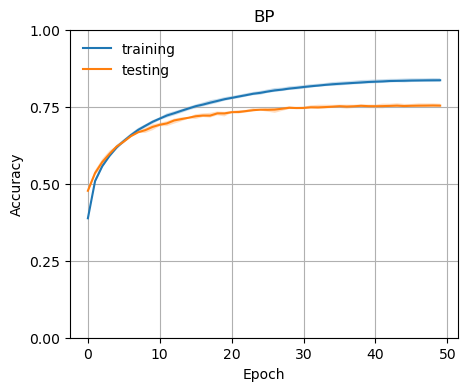

In [5]:

for ifbsc in range(len(fbsc_range)):
    testacctt = np.max(res[ifbsc,:,2,:], axis= -1)

    trainacctt = np.max(res[ifbsc,:,1,:], axis= -1)

    print(f'\t_'
        f"train: {np.mean(trainacctt) * 100:.2f}%+-{np.std(trainacctt, ddof=1)*100:.2f}% ({np.min(trainacctt) * 100:.2f}% {np.max(trainacctt) * 100:.2f}%)"
        f"\t test: {np.mean(testacctt) * 100:.2f}%+-{np.std(testacctt, ddof=1)*100:.2f}% ({np.min(testacctt) * 100:.2f}% {np.max(testacctt) * 100:.2f}%)\n")

for ifbsc in range(len(fbsc_range)):
    plt.figure(figsize=(5, 4))
    tt = res[ifbsc,:,1,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'training')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    tt = res[ifbsc,:,2,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'testing')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    if np.min(tt)<0.8:
        plt.ylim([0.0, 1.0])
        plt.yticks(np.arange(0.0,1.01,0.25))
    else:
        plt.ylim([0.9, 1.0])
        plt.yticks(np.arange(0.9,1.01,0.02))
    plt.grid()
    plt.title(f"BP")
    plt.xlabel(f'Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False)

    current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(f'Current Time: {current_time}')
    plt.savefig(res_path /f"BP_cnn_MNIST_maxacc{np.max(tt)}-fbsc{fbsc_range[ifbsc]}-{current_time}.svg", format="svg")


### EP conv with weak feedback

In [6]:

num_epochs = 50
multest = 5 #5
fbsc_range = [0] # 0.01, 0.1, 1
res = np.zeros((len(fbsc_range),multest,3,num_epochs))
for ifbsc in range(len(fbsc_range)):
    for imul in range(multest):
        
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{ifbsc} start at {current_time_tmp}")

        model = aEP_CNN(fbsc=0.01, nudge=0.25, deviden=False, T=40, K=10, chl=[32,64,128])
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=2.5e-4, weight_decay=2e-4) # 2.5 ~ 1e-4 0.5e-4
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 
                                         T_max=num_epochs,  
                                         eta_min=1e-6) 
        
        for epoch in range(num_epochs):
            total_loss = 0
            correct = 0
            total = 0

            random.shuffle(train_loader_gpu)
            with tqdm(total=len(train_loader_gpu), desc=f"Epoch {epoch + 1}/{num_epochs}:", unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                for batch_idx, (data, target) in enumerate(train_loader_gpu):
                    optimizer.zero_grad()
                    # model.bw_symm()
                    preds, loss = model.ep_step(data, target)# eta=[0.015, 0.035, 0.15]
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
                    optimizer.step()
                    total_loss += loss

                    if batch_idx % 10 == 0: 
                        pbar.set_postfix({'loss': f'{total_loss/(batch_idx+1):.6f}'})  
                        pbar.update(10)

                    correct += (preds == target).sum().item()
                    total += target.size(0)
                                    
            scheduler.step()

            acc = correct / total
            avg_loss = total_loss / len(train_loader_gpu)
            res[ifbsc,imul,0,epoch]=(avg_loss)
            res[ifbsc,imul,1,epoch]=(acc)

            # Test
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader_gpu:
                    preds = model.predict(data)
                    correct += (preds == target).sum().item()
                    total += target.size(0)
            test_acc = correct / total
            res[ifbsc,imul,2,epoch]=(test_acc)

            print(f"Epoch {epoch+1} Train Loss = {avg_loss:.4f}, Accuracy = {acc*100:.2f}%, Test Accuracy = {test_acc*100:.2f}%")
        
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{ifbsc}-{imul} end at {current_time_tmp}")
        
res_aEP = res
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if fsave: 
    save_dict = {
        "res": res
}
np.savez_compressed(res_path / f"res_aEP",  **save_dict)
     

0 start at 20250924-164515


Epoch 1/50:: 400batch [00:25, 15.58batch/s, loss=1.707588]                                1.707588]


Epoch 1 Train Loss = 1.7076, Accuracy = 38.52%, Test Accuracy = 47.57%


Epoch 2/50:: 400batch [00:25, 15.76batch/s, loss=1.388959]                                1.388959]


Epoch 2 Train Loss = 1.3890, Accuracy = 50.45%, Test Accuracy = 51.92%


Epoch 3/50:: 400batch [00:25, 15.57batch/s, loss=1.278278]                                1.278278]


Epoch 3 Train Loss = 1.2783, Accuracy = 54.84%, Test Accuracy = 56.29%


Epoch 4/50:: 400batch [00:25, 15.75batch/s, loss=1.192730]                                1.192730]


Epoch 4 Train Loss = 1.1927, Accuracy = 58.16%, Test Accuracy = 57.94%


Epoch 5/50:: 400batch [00:25, 15.79batch/s, loss=1.123274]                                1.123274]


Epoch 5 Train Loss = 1.1233, Accuracy = 60.75%, Test Accuracy = 60.98%


Epoch 6/50:: 400batch [00:25, 15.75batch/s, loss=1.059073]                                1.059073]


Epoch 6 Train Loss = 1.0591, Accuracy = 63.04%, Test Accuracy = 63.21%


Epoch 7/50:: 400batch [00:25, 15.88batch/s, loss=1.004009]                                1.004009]


Epoch 7 Train Loss = 1.0040, Accuracy = 65.01%, Test Accuracy = 64.37%


Epoch 8/50:: 400batch [00:25, 15.79batch/s, loss=0.965686]                                0.965686]


Epoch 8 Train Loss = 0.9657, Accuracy = 66.27%, Test Accuracy = 65.42%


Epoch 9/50:: 400batch [00:25, 15.65batch/s, loss=0.923676]                                0.923676]


Epoch 9 Train Loss = 0.9237, Accuracy = 67.93%, Test Accuracy = 67.44%


Epoch 10/50:: 400batch [00:26, 15.38batch/s, loss=0.893528]                               0.893528]


Epoch 10 Train Loss = 0.8935, Accuracy = 68.84%, Test Accuracy = 68.58%


Epoch 11/50:: 400batch [00:26, 15.30batch/s, loss=0.862469]                               0.862469]


Epoch 11 Train Loss = 0.8625, Accuracy = 70.10%, Test Accuracy = 68.41%


Epoch 12/50:: 400batch [00:25, 15.71batch/s, loss=0.836553]                               0.836553]


Epoch 12 Train Loss = 0.8366, Accuracy = 71.06%, Test Accuracy = 69.95%


Epoch 13/50:: 400batch [00:25, 15.59batch/s, loss=0.814099]                               0.814099]


Epoch 13 Train Loss = 0.8141, Accuracy = 71.97%, Test Accuracy = 70.05%


Epoch 14/50:: 400batch [00:25, 15.52batch/s, loss=0.798884]                               0.798884]


Epoch 14 Train Loss = 0.7989, Accuracy = 72.35%, Test Accuracy = 70.53%


Epoch 15/50:: 400batch [00:25, 15.45batch/s, loss=0.778698]                               0.778698]


Epoch 15 Train Loss = 0.7787, Accuracy = 73.12%, Test Accuracy = 70.98%


Epoch 16/50:: 400batch [00:26, 15.34batch/s, loss=0.762440]                               0.762440]


Epoch 16 Train Loss = 0.7624, Accuracy = 73.85%, Test Accuracy = 71.45%


Epoch 17/50:: 400batch [00:25, 15.43batch/s, loss=0.744785]                               0.744785]


Epoch 17 Train Loss = 0.7448, Accuracy = 74.39%, Test Accuracy = 71.95%


Epoch 18/50:: 400batch [00:25, 15.60batch/s, loss=0.730241]                               0.730241]


Epoch 18 Train Loss = 0.7302, Accuracy = 74.79%, Test Accuracy = 71.63%


Epoch 19/50:: 400batch [00:26, 15.34batch/s, loss=0.716864]                               0.716864]


Epoch 19 Train Loss = 0.7169, Accuracy = 75.38%, Test Accuracy = 72.84%


Epoch 20/50:: 400batch [00:26, 15.34batch/s, loss=0.704434]                               0.704434]


Epoch 20 Train Loss = 0.7044, Accuracy = 75.63%, Test Accuracy = 73.38%


Epoch 21/50:: 400batch [00:25, 15.48batch/s, loss=0.691785]                               0.691785]


Epoch 21 Train Loss = 0.6918, Accuracy = 76.36%, Test Accuracy = 72.78%


Epoch 22/50:: 400batch [00:25, 15.62batch/s, loss=0.682276]                               0.682276]


Epoch 22 Train Loss = 0.6823, Accuracy = 76.66%, Test Accuracy = 73.50%


Epoch 23/50:: 400batch [00:25, 15.69batch/s, loss=0.669456]                               0.669456]


Epoch 23 Train Loss = 0.6695, Accuracy = 77.02%, Test Accuracy = 73.66%


Epoch 24/50:: 400batch [00:25, 15.41batch/s, loss=0.659810]                               0.659810]


Epoch 24 Train Loss = 0.6598, Accuracy = 77.48%, Test Accuracy = 74.10%


Epoch 25/50:: 400batch [00:25, 15.86batch/s, loss=0.650262]                               0.650262]


Epoch 25 Train Loss = 0.6503, Accuracy = 77.80%, Test Accuracy = 73.90%


Epoch 26/50:: 400batch [00:25, 15.71batch/s, loss=0.642871]                               0.642871]


Epoch 26 Train Loss = 0.6429, Accuracy = 77.91%, Test Accuracy = 74.11%


Epoch 27/50:: 400batch [00:25, 15.74batch/s, loss=0.635067]                               0.635067]


Epoch 27 Train Loss = 0.6351, Accuracy = 78.31%, Test Accuracy = 74.17%


Epoch 28/50:: 400batch [00:25, 15.65batch/s, loss=0.627516]                               0.627516]


Epoch 28 Train Loss = 0.6275, Accuracy = 78.50%, Test Accuracy = 73.94%


Epoch 29/50:: 400batch [00:25, 15.48batch/s, loss=0.620839]                               0.620839]


Epoch 29 Train Loss = 0.6208, Accuracy = 78.81%, Test Accuracy = 74.23%


Epoch 30/50:: 400batch [00:25, 15.85batch/s, loss=0.614677]                               0.614677]


Epoch 30 Train Loss = 0.6147, Accuracy = 79.26%, Test Accuracy = 74.65%


Epoch 31/50:: 400batch [00:25, 15.59batch/s, loss=0.608324]                               0.608324]


Epoch 31 Train Loss = 0.6083, Accuracy = 79.30%, Test Accuracy = 74.73%


Epoch 32/50:: 400batch [00:25, 15.53batch/s, loss=0.602377]                               0.602377]


Epoch 32 Train Loss = 0.6024, Accuracy = 79.57%, Test Accuracy = 74.98%


Epoch 33/50:: 400batch [00:25, 15.56batch/s, loss=0.598047]                               0.598047]


Epoch 33 Train Loss = 0.5980, Accuracy = 79.73%, Test Accuracy = 74.29%


Epoch 34/50:: 400batch [00:25, 15.94batch/s, loss=0.591799]                               0.591799]


Epoch 34 Train Loss = 0.5918, Accuracy = 79.95%, Test Accuracy = 74.68%


Epoch 35/50:: 400batch [00:25, 15.90batch/s, loss=0.588188]                               0.588188]


Epoch 35 Train Loss = 0.5882, Accuracy = 80.22%, Test Accuracy = 75.04%


Epoch 36/50:: 400batch [00:25, 15.80batch/s, loss=0.585119]                               0.585119]


Epoch 36 Train Loss = 0.5851, Accuracy = 80.23%, Test Accuracy = 75.03%


Epoch 37/50:: 400batch [00:25, 15.82batch/s, loss=0.580297]                               0.580297]


Epoch 37 Train Loss = 0.5803, Accuracy = 80.37%, Test Accuracy = 75.30%


Epoch 38/50:: 400batch [00:25, 15.67batch/s, loss=0.578036]                               0.578036]


Epoch 38 Train Loss = 0.5780, Accuracy = 80.48%, Test Accuracy = 75.00%


Epoch 39/50:: 400batch [00:25, 15.89batch/s, loss=0.574122]                               0.574122]


Epoch 39 Train Loss = 0.5741, Accuracy = 80.74%, Test Accuracy = 75.64%


Epoch 40/50:: 400batch [00:24, 16.02batch/s, loss=0.571949]                               0.571949]


Epoch 40 Train Loss = 0.5719, Accuracy = 80.73%, Test Accuracy = 75.54%


Epoch 41/50:: 400batch [00:25, 15.74batch/s, loss=0.569791]                               0.569791]


Epoch 41 Train Loss = 0.5698, Accuracy = 80.79%, Test Accuracy = 75.61%


Epoch 42/50:: 400batch [00:25, 15.86batch/s, loss=0.567610]                               0.567610]


Epoch 42 Train Loss = 0.5676, Accuracy = 80.85%, Test Accuracy = 75.63%


Epoch 43/50:: 400batch [00:25, 15.57batch/s, loss=0.565873]                               0.565873]


Epoch 43 Train Loss = 0.5659, Accuracy = 81.02%, Test Accuracy = 75.63%


Epoch 44/50:: 400batch [00:25, 15.90batch/s, loss=0.564256]                               0.564256]


Epoch 44 Train Loss = 0.5643, Accuracy = 81.14%, Test Accuracy = 75.56%


Epoch 45/50:: 400batch [00:25, 15.78batch/s, loss=0.563013]                               0.563013]


Epoch 45 Train Loss = 0.5630, Accuracy = 81.10%, Test Accuracy = 75.69%


Epoch 46/50:: 400batch [00:24, 16.07batch/s, loss=0.561984]                               0.561984]


Epoch 46 Train Loss = 0.5620, Accuracy = 81.15%, Test Accuracy = 75.68%


Epoch 47/50:: 400batch [00:25, 15.88batch/s, loss=0.561220]                               0.561220]


Epoch 47 Train Loss = 0.5612, Accuracy = 81.23%, Test Accuracy = 75.72%


Epoch 48/50:: 400batch [00:25, 15.54batch/s, loss=0.560392]                               0.560392]


Epoch 48 Train Loss = 0.5604, Accuracy = 81.27%, Test Accuracy = 75.71%


Epoch 49/50:: 400batch [00:25, 15.82batch/s, loss=0.559964]                               0.559964]


Epoch 49 Train Loss = 0.5600, Accuracy = 81.27%, Test Accuracy = 75.72%


Epoch 50/50:: 400batch [00:25, 15.54batch/s, loss=0.559723]                               0.559723]


Epoch 50 Train Loss = 0.5597, Accuracy = 81.25%, Test Accuracy = 75.74%
0-0 end at 20250924-170912
0 start at 20250924-170912


Epoch 1/50:: 400batch [00:25, 15.65batch/s, loss=1.710356]                                1.710356]


Epoch 1 Train Loss = 1.7104, Accuracy = 38.29%, Test Accuracy = 47.10%


Epoch 2/50:: 400batch [00:25, 15.87batch/s, loss=1.403055]                                1.403055]


Epoch 2 Train Loss = 1.4031, Accuracy = 49.68%, Test Accuracy = 51.73%


Epoch 3/50:: 400batch [00:25, 15.84batch/s, loss=1.288142]                                1.288142]


Epoch 3 Train Loss = 1.2881, Accuracy = 54.37%, Test Accuracy = 54.74%


Epoch 4/50:: 400batch [00:25, 15.50batch/s, loss=1.197061]                                1.197061]


Epoch 4 Train Loss = 1.1971, Accuracy = 57.83%, Test Accuracy = 58.42%


Epoch 5/50:: 400batch [00:25, 15.61batch/s, loss=1.124065]                                1.124065]


Epoch 5 Train Loss = 1.1241, Accuracy = 60.63%, Test Accuracy = 60.37%


Epoch 6/50:: 400batch [00:25, 15.61batch/s, loss=1.058616]                                1.058616]


Epoch 6 Train Loss = 1.0586, Accuracy = 62.97%, Test Accuracy = 63.51%


Epoch 7/50:: 400batch [00:25, 15.87batch/s, loss=1.005363]                                1.005363]


Epoch 7 Train Loss = 1.0054, Accuracy = 64.85%, Test Accuracy = 65.00%


Epoch 8/50:: 400batch [00:25, 15.63batch/s, loss=0.964657]                                0.964657]


Epoch 8 Train Loss = 0.9647, Accuracy = 66.47%, Test Accuracy = 66.00%


Epoch 9/50:: 400batch [00:25, 15.83batch/s, loss=0.930017]                                0.930017]


Epoch 9 Train Loss = 0.9300, Accuracy = 67.54%, Test Accuracy = 67.34%


Epoch 10/50:: 400batch [00:25, 15.50batch/s, loss=0.899693]                               0.899693]


Epoch 10 Train Loss = 0.8997, Accuracy = 68.92%, Test Accuracy = 67.95%


Epoch 11/50:: 400batch [00:25, 15.88batch/s, loss=0.873714]                               0.873714]


Epoch 11 Train Loss = 0.8737, Accuracy = 69.97%, Test Accuracy = 68.63%


Epoch 12/50:: 400batch [00:25, 15.90batch/s, loss=0.851104]                               0.851104]


Epoch 12 Train Loss = 0.8511, Accuracy = 70.63%, Test Accuracy = 68.36%


Epoch 13/50:: 400batch [00:25, 15.56batch/s, loss=0.829969]                               0.829969]


Epoch 13 Train Loss = 0.8300, Accuracy = 71.49%, Test Accuracy = 69.55%


Epoch 14/50:: 400batch [00:25, 15.72batch/s, loss=0.810478]                               0.810478]


Epoch 14 Train Loss = 0.8105, Accuracy = 72.17%, Test Accuracy = 69.78%


Epoch 15/50:: 400batch [00:25, 15.67batch/s, loss=0.793633]                               0.793633]


Epoch 15 Train Loss = 0.7936, Accuracy = 72.84%, Test Accuracy = 70.54%


Epoch 16/50:: 400batch [00:25, 15.95batch/s, loss=0.776264]                               0.776264]


Epoch 16 Train Loss = 0.7763, Accuracy = 73.45%, Test Accuracy = 70.53%


Epoch 17/50:: 400batch [00:25, 15.60batch/s, loss=0.760117]                               0.760117]


Epoch 17 Train Loss = 0.7601, Accuracy = 74.02%, Test Accuracy = 71.23%


Epoch 18/50:: 400batch [00:25, 15.71batch/s, loss=0.747741]                               0.747741]


Epoch 18 Train Loss = 0.7477, Accuracy = 74.45%, Test Accuracy = 71.36%


Epoch 19/50:: 400batch [00:25, 15.59batch/s, loss=0.733547]                               0.733547]


Epoch 19 Train Loss = 0.7335, Accuracy = 74.91%, Test Accuracy = 71.45%


Epoch 20/50:: 400batch [00:25, 15.56batch/s, loss=0.720774]                               0.720774]


Epoch 20 Train Loss = 0.7208, Accuracy = 75.30%, Test Accuracy = 71.47%


Epoch 21/50:: 400batch [00:25, 15.76batch/s, loss=0.707714]                               0.707714]


Epoch 21 Train Loss = 0.7077, Accuracy = 75.80%, Test Accuracy = 72.43%


Epoch 22/50:: 400batch [00:25, 15.42batch/s, loss=0.698699]                               0.698699]


Epoch 22 Train Loss = 0.6987, Accuracy = 76.20%, Test Accuracy = 71.87%


Epoch 23/50:: 400batch [00:25, 15.76batch/s, loss=0.687908]                               0.687908]


Epoch 23 Train Loss = 0.6879, Accuracy = 76.42%, Test Accuracy = 71.84%


Epoch 24/50:: 400batch [00:25, 15.68batch/s, loss=0.678915]                               0.678915]


Epoch 24 Train Loss = 0.6789, Accuracy = 76.87%, Test Accuracy = 72.82%


Epoch 25/50:: 400batch [00:25, 15.50batch/s, loss=0.671792]                               0.671792]


Epoch 25 Train Loss = 0.6718, Accuracy = 77.08%, Test Accuracy = 72.48%


Epoch 26/50:: 400batch [00:25, 15.91batch/s, loss=0.661250]                               0.661250]


Epoch 26 Train Loss = 0.6613, Accuracy = 77.45%, Test Accuracy = 72.95%


Epoch 27/50:: 400batch [00:25, 15.87batch/s, loss=0.651170]                               0.651170]


Epoch 27 Train Loss = 0.6512, Accuracy = 77.90%, Test Accuracy = 72.84%


Epoch 28/50:: 400batch [00:25, 15.84batch/s, loss=0.645668]                               0.645668]


Epoch 28 Train Loss = 0.6457, Accuracy = 77.95%, Test Accuracy = 73.05%


Epoch 29/50:: 400batch [00:25, 15.95batch/s, loss=0.639704]                               0.639704]


Epoch 29 Train Loss = 0.6397, Accuracy = 78.22%, Test Accuracy = 73.48%


Epoch 30/50:: 400batch [00:25, 15.89batch/s, loss=0.633069]                               0.633069]


Epoch 30 Train Loss = 0.6331, Accuracy = 78.46%, Test Accuracy = 73.75%


Epoch 31/50:: 400batch [00:24, 16.01batch/s, loss=0.626604]                               0.626604]


Epoch 31 Train Loss = 0.6266, Accuracy = 78.71%, Test Accuracy = 73.55%


Epoch 32/50:: 400batch [00:25, 15.86batch/s, loss=0.619912]                               0.619912]


Epoch 32 Train Loss = 0.6199, Accuracy = 79.08%, Test Accuracy = 73.49%


Epoch 33/50:: 400batch [00:25, 15.67batch/s, loss=0.614486]                               0.614486]


Epoch 33 Train Loss = 0.6145, Accuracy = 79.31%, Test Accuracy = 73.42%


Epoch 34/50:: 400batch [00:25, 15.77batch/s, loss=0.610172]                               0.610172]


Epoch 34 Train Loss = 0.6102, Accuracy = 79.29%, Test Accuracy = 73.65%


Epoch 35/50:: 400batch [00:25, 15.82batch/s, loss=0.606050]                               0.606050]


Epoch 35 Train Loss = 0.6060, Accuracy = 79.42%, Test Accuracy = 73.94%


Epoch 36/50:: 400batch [00:25, 15.74batch/s, loss=0.601529]                               0.601529]


Epoch 36 Train Loss = 0.6015, Accuracy = 79.64%, Test Accuracy = 73.72%


Epoch 37/50:: 400batch [00:25, 15.78batch/s, loss=0.597303]                               0.597303]


Epoch 37 Train Loss = 0.5973, Accuracy = 79.87%, Test Accuracy = 73.67%


Epoch 38/50:: 400batch [00:25, 15.97batch/s, loss=0.594209]                               0.594209]


Epoch 38 Train Loss = 0.5942, Accuracy = 79.89%, Test Accuracy = 74.25%


Epoch 39/50:: 400batch [00:25, 15.93batch/s, loss=0.591062]                               0.591062]


Epoch 39 Train Loss = 0.5911, Accuracy = 80.14%, Test Accuracy = 74.20%


Epoch 40/50:: 400batch [00:25, 15.98batch/s, loss=0.588648]                               0.588648]


Epoch 40 Train Loss = 0.5886, Accuracy = 80.24%, Test Accuracy = 74.01%


Epoch 41/50:: 400batch [00:25, 15.98batch/s, loss=0.586691]                               0.586691]


Epoch 41 Train Loss = 0.5867, Accuracy = 80.22%, Test Accuracy = 74.19%


Epoch 42/50:: 400batch [00:25, 15.82batch/s, loss=0.584370]                               0.584370]


Epoch 42 Train Loss = 0.5844, Accuracy = 80.45%, Test Accuracy = 74.18%


Epoch 43/50:: 400batch [00:25, 15.64batch/s, loss=0.582435]                               0.582435]


Epoch 43 Train Loss = 0.5824, Accuracy = 80.43%, Test Accuracy = 74.09%


Epoch 44/50:: 400batch [00:25, 15.77batch/s, loss=0.581193]                               0.581193]


Epoch 44 Train Loss = 0.5812, Accuracy = 80.57%, Test Accuracy = 74.30%


Epoch 45/50:: 400batch [00:25, 15.78batch/s, loss=0.579523]                               0.579523]


Epoch 45 Train Loss = 0.5795, Accuracy = 80.61%, Test Accuracy = 74.19%


Epoch 46/50:: 400batch [00:25, 15.92batch/s, loss=0.578686]                               0.578686]


Epoch 46 Train Loss = 0.5787, Accuracy = 80.64%, Test Accuracy = 74.31%


Epoch 47/50:: 400batch [00:25, 15.83batch/s, loss=0.577781]                               0.577781]


Epoch 47 Train Loss = 0.5778, Accuracy = 80.62%, Test Accuracy = 74.14%


Epoch 48/50:: 400batch [00:25, 15.88batch/s, loss=0.577339]                               0.577339]


Epoch 48 Train Loss = 0.5773, Accuracy = 80.66%, Test Accuracy = 74.28%


Epoch 49/50:: 400batch [00:25, 15.88batch/s, loss=0.576889]                               0.576889]


Epoch 49 Train Loss = 0.5769, Accuracy = 80.68%, Test Accuracy = 74.23%


Epoch 50/50:: 400batch [00:25, 15.83batch/s, loss=0.576619]                               0.576619]


Epoch 50 Train Loss = 0.5766, Accuracy = 80.75%, Test Accuracy = 74.35%
0-1 end at 20250924-173301
0 start at 20250924-173301


Epoch 1/50:: 400batch [00:25, 15.74batch/s, loss=1.727059]                                1.727059]


Epoch 1 Train Loss = 1.7271, Accuracy = 37.70%, Test Accuracy = 47.82%


Epoch 2/50:: 400batch [00:25, 15.78batch/s, loss=1.398844]                                1.398844]


Epoch 2 Train Loss = 1.3988, Accuracy = 50.08%, Test Accuracy = 53.19%


Epoch 3/50:: 400batch [00:25, 15.57batch/s, loss=1.282161]                                1.282161]


Epoch 3 Train Loss = 1.2822, Accuracy = 54.55%, Test Accuracy = 56.89%


Epoch 4/50:: 400batch [00:25, 15.57batch/s, loss=1.192193]                                1.192193]


Epoch 4 Train Loss = 1.1922, Accuracy = 58.15%, Test Accuracy = 59.07%


Epoch 5/50:: 400batch [00:25, 15.57batch/s, loss=1.120263]                                1.120263]


Epoch 5 Train Loss = 1.1203, Accuracy = 60.85%, Test Accuracy = 61.80%


Epoch 6/50:: 400batch [00:25, 15.89batch/s, loss=1.061269]                                1.061269]


Epoch 6 Train Loss = 1.0613, Accuracy = 63.03%, Test Accuracy = 61.98%


Epoch 7/50:: 400batch [00:25, 15.59batch/s, loss=1.011953]                                1.011953]


Epoch 7 Train Loss = 1.0120, Accuracy = 64.87%, Test Accuracy = 63.95%


Epoch 8/50:: 400batch [00:25, 15.87batch/s, loss=0.966681]                                0.966681]


Epoch 8 Train Loss = 0.9667, Accuracy = 66.65%, Test Accuracy = 65.78%


Epoch 9/50:: 400batch [00:25, 15.73batch/s, loss=0.929761]                                0.929761]


Epoch 9 Train Loss = 0.9298, Accuracy = 67.89%, Test Accuracy = 65.57%


Epoch 10/50:: 400batch [00:25, 15.46batch/s, loss=0.899303]                               0.899303]


Epoch 10 Train Loss = 0.8993, Accuracy = 68.88%, Test Accuracy = 67.65%


Epoch 11/50:: 400batch [00:25, 15.60batch/s, loss=0.874636]                               0.874636]


Epoch 11 Train Loss = 0.8746, Accuracy = 69.86%, Test Accuracy = 69.25%


Epoch 12/50:: 400batch [00:26, 15.04batch/s, loss=0.848363]                               0.848363]


Epoch 12 Train Loss = 0.8484, Accuracy = 70.76%, Test Accuracy = 69.80%


Epoch 13/50:: 400batch [00:25, 15.55batch/s, loss=0.824574]                               0.824574]


Epoch 13 Train Loss = 0.8246, Accuracy = 71.80%, Test Accuracy = 70.40%


Epoch 14/50:: 400batch [00:26, 15.27batch/s, loss=0.807609]                               0.807609]


Epoch 14 Train Loss = 0.8076, Accuracy = 72.27%, Test Accuracy = 70.49%


Epoch 15/50:: 400batch [00:25, 15.84batch/s, loss=0.791804]                               0.791804]


Epoch 15 Train Loss = 0.7918, Accuracy = 72.78%, Test Accuracy = 70.02%


Epoch 16/50:: 400batch [00:25, 15.66batch/s, loss=0.777055]                               0.777055]


Epoch 16 Train Loss = 0.7771, Accuracy = 73.32%, Test Accuracy = 71.05%


Epoch 17/50:: 400batch [00:25, 15.64batch/s, loss=0.759156]                               0.759156]


Epoch 17 Train Loss = 0.7592, Accuracy = 73.94%, Test Accuracy = 71.71%


Epoch 18/50:: 400batch [00:25, 15.55batch/s, loss=0.745917]                               0.745917]


Epoch 18 Train Loss = 0.7459, Accuracy = 74.55%, Test Accuracy = 71.42%


Epoch 19/50:: 400batch [00:25, 15.79batch/s, loss=0.730553]                               0.730553]


Epoch 19 Train Loss = 0.7306, Accuracy = 75.17%, Test Accuracy = 70.82%


Epoch 20/50:: 400batch [00:25, 15.54batch/s, loss=0.719352]                               0.719352]


Epoch 20 Train Loss = 0.7194, Accuracy = 75.45%, Test Accuracy = 70.87%


Epoch 21/50:: 400batch [00:25, 15.75batch/s, loss=0.708452]                               0.708452]


Epoch 21 Train Loss = 0.7085, Accuracy = 75.83%, Test Accuracy = 72.90%


Epoch 22/50:: 400batch [00:25, 15.96batch/s, loss=0.696222]                               0.696222]


Epoch 22 Train Loss = 0.6962, Accuracy = 76.16%, Test Accuracy = 72.31%


Epoch 23/50:: 400batch [00:25, 15.75batch/s, loss=0.686977]                               0.686977]


Epoch 23 Train Loss = 0.6870, Accuracy = 76.47%, Test Accuracy = 73.17%


Epoch 24/50:: 400batch [00:25, 15.62batch/s, loss=0.677106]                               0.677106]


Epoch 24 Train Loss = 0.6771, Accuracy = 77.00%, Test Accuracy = 73.06%


Epoch 25/50:: 400batch [00:25, 15.83batch/s, loss=0.667567]                               0.667567]


Epoch 25 Train Loss = 0.6676, Accuracy = 77.27%, Test Accuracy = 72.91%


Epoch 26/50:: 400batch [00:25, 15.77batch/s, loss=0.659620]                               0.659620]


Epoch 26 Train Loss = 0.6596, Accuracy = 77.71%, Test Accuracy = 73.48%


Epoch 27/50:: 400batch [00:25, 15.41batch/s, loss=0.651246]                               0.651246]


Epoch 27 Train Loss = 0.6512, Accuracy = 77.85%, Test Accuracy = 73.44%


Epoch 28/50:: 400batch [00:25, 15.53batch/s, loss=0.644822]                               0.644822]


Epoch 28 Train Loss = 0.6448, Accuracy = 78.00%, Test Accuracy = 73.65%


Epoch 29/50:: 400batch [00:25, 15.58batch/s, loss=0.637316]                               0.637316]


Epoch 29 Train Loss = 0.6373, Accuracy = 78.29%, Test Accuracy = 73.46%


Epoch 30/50:: 400batch [00:25, 15.56batch/s, loss=0.633262]                               0.633262]


Epoch 30 Train Loss = 0.6333, Accuracy = 78.49%, Test Accuracy = 73.80%


Epoch 31/50:: 400batch [00:25, 15.72batch/s, loss=0.628775]                               0.628775]


Epoch 31 Train Loss = 0.6288, Accuracy = 78.67%, Test Accuracy = 73.70%


Epoch 32/50:: 400batch [00:25, 15.76batch/s, loss=0.623092]                               0.623092]


Epoch 32 Train Loss = 0.6231, Accuracy = 78.83%, Test Accuracy = 74.16%


Epoch 33/50:: 400batch [00:25, 15.54batch/s, loss=0.618069]                               0.618069]


Epoch 33 Train Loss = 0.6181, Accuracy = 79.03%, Test Accuracy = 74.32%


Epoch 34/50:: 400batch [00:25, 15.71batch/s, loss=0.615021]                               0.615021]


Epoch 34 Train Loss = 0.6150, Accuracy = 79.14%, Test Accuracy = 74.21%


Epoch 35/50:: 400batch [00:25, 15.50batch/s, loss=0.610418]                               0.610418]


Epoch 35 Train Loss = 0.6104, Accuracy = 79.38%, Test Accuracy = 74.49%


Epoch 36/50:: 400batch [00:25, 15.56batch/s, loss=0.606405]                               0.606405]


Epoch 36 Train Loss = 0.6064, Accuracy = 79.52%, Test Accuracy = 74.33%


Epoch 37/50:: 400batch [00:25, 15.60batch/s, loss=0.603234]                               0.603234]


Epoch 37 Train Loss = 0.6032, Accuracy = 79.60%, Test Accuracy = 74.46%


Epoch 38/50:: 400batch [00:26, 15.36batch/s, loss=0.598515]                               0.598515]


Epoch 38 Train Loss = 0.5985, Accuracy = 79.78%, Test Accuracy = 74.50%


Epoch 39/50:: 400batch [00:25, 15.89batch/s, loss=0.595461]                               0.595461]


Epoch 39 Train Loss = 0.5955, Accuracy = 79.82%, Test Accuracy = 74.59%


Epoch 40/50:: 400batch [00:25, 15.49batch/s, loss=0.592731]                               0.592731]


Epoch 40 Train Loss = 0.5927, Accuracy = 80.09%, Test Accuracy = 74.73%


Epoch 41/50:: 400batch [00:25, 15.53batch/s, loss=0.590479]                               0.590479]


Epoch 41 Train Loss = 0.5905, Accuracy = 80.15%, Test Accuracy = 74.50%


Epoch 42/50:: 400batch [00:25, 15.75batch/s, loss=0.588052]                               0.588052]


Epoch 42 Train Loss = 0.5881, Accuracy = 80.21%, Test Accuracy = 74.56%


Epoch 43/50:: 400batch [00:25, 15.57batch/s, loss=0.586474]                               0.586474]


Epoch 43 Train Loss = 0.5865, Accuracy = 80.27%, Test Accuracy = 74.83%


Epoch 44/50:: 400batch [00:26, 15.17batch/s, loss=0.585229]                               0.585229]


Epoch 44 Train Loss = 0.5852, Accuracy = 80.30%, Test Accuracy = 74.64%


Epoch 45/50:: 400batch [00:26, 15.28batch/s, loss=0.583865]                               0.583865]


Epoch 45 Train Loss = 0.5839, Accuracy = 80.22%, Test Accuracy = 74.76%


Epoch 46/50:: 400batch [00:25, 15.54batch/s, loss=0.582746]                               0.582746]


Epoch 46 Train Loss = 0.5827, Accuracy = 80.38%, Test Accuracy = 74.61%


Epoch 47/50:: 400batch [00:26, 15.06batch/s, loss=0.582011]                               0.582011]


Epoch 47 Train Loss = 0.5820, Accuracy = 80.38%, Test Accuracy = 74.55%


Epoch 48/50:: 400batch [00:26, 15.26batch/s, loss=0.581601]                               0.581601]


Epoch 48 Train Loss = 0.5816, Accuracy = 80.41%, Test Accuracy = 74.77%


Epoch 49/50:: 400batch [00:25, 15.57batch/s, loss=0.580997]                               0.580997]


Epoch 49 Train Loss = 0.5810, Accuracy = 80.43%, Test Accuracy = 74.68%


Epoch 50/50:: 400batch [00:26, 15.35batch/s, loss=0.580700]                               0.580700]


Epoch 50 Train Loss = 0.5807, Accuracy = 80.40%, Test Accuracy = 74.84%
0-2 end at 20250924-175705
0 start at 20250924-175705


Epoch 1/50:: 400batch [00:25, 15.55batch/s, loss=1.725832]                                1.725832]


Epoch 1 Train Loss = 1.7258, Accuracy = 37.78%, Test Accuracy = 47.50%


Epoch 2/50:: 400batch [00:25, 15.57batch/s, loss=1.404613]                                1.404613]


Epoch 2 Train Loss = 1.4046, Accuracy = 49.74%, Test Accuracy = 52.51%


Epoch 3/50:: 400batch [00:26, 15.17batch/s, loss=1.295872]                                1.295872]


Epoch 3 Train Loss = 1.2959, Accuracy = 53.83%, Test Accuracy = 56.01%


Epoch 4/50:: 400batch [00:25, 15.69batch/s, loss=1.211673]                                1.211673]


Epoch 4 Train Loss = 1.2117, Accuracy = 57.23%, Test Accuracy = 58.16%


Epoch 5/50:: 400batch [00:25, 15.91batch/s, loss=1.140069]                                1.140069]


Epoch 5 Train Loss = 1.1401, Accuracy = 59.80%, Test Accuracy = 60.45%


Epoch 6/50:: 400batch [00:25, 15.57batch/s, loss=1.073785]                                1.073785]


Epoch 6 Train Loss = 1.0738, Accuracy = 62.59%, Test Accuracy = 63.15%


Epoch 7/50:: 400batch [00:25, 15.55batch/s, loss=1.018474]                                1.018474]


Epoch 7 Train Loss = 1.0185, Accuracy = 64.48%, Test Accuracy = 65.03%


Epoch 8/50:: 400batch [00:25, 15.69batch/s, loss=0.974401]                                0.974401]


Epoch 8 Train Loss = 0.9744, Accuracy = 66.12%, Test Accuracy = 66.58%


Epoch 9/50:: 400batch [00:25, 15.61batch/s, loss=0.936787]                                0.936787]


Epoch 9 Train Loss = 0.9368, Accuracy = 67.52%, Test Accuracy = 67.06%


Epoch 10/50:: 400batch [00:25, 15.69batch/s, loss=0.903646]                               0.903646]


Epoch 10 Train Loss = 0.9036, Accuracy = 68.58%, Test Accuracy = 66.63%


Epoch 11/50:: 400batch [00:25, 15.50batch/s, loss=0.878149]                               0.878149]


Epoch 11 Train Loss = 0.8781, Accuracy = 69.56%, Test Accuracy = 69.38%


Epoch 12/50:: 400batch [00:25, 15.66batch/s, loss=0.847609]                               0.847609]


Epoch 12 Train Loss = 0.8476, Accuracy = 70.58%, Test Accuracy = 69.30%


Epoch 13/50:: 400batch [00:25, 15.78batch/s, loss=0.828939]                               0.828939]


Epoch 13 Train Loss = 0.8289, Accuracy = 71.28%, Test Accuracy = 69.68%


Epoch 14/50:: 400batch [00:25, 15.74batch/s, loss=0.808516]                               0.808516]


Epoch 14 Train Loss = 0.8085, Accuracy = 72.03%, Test Accuracy = 70.71%


Epoch 15/50:: 400batch [00:25, 15.49batch/s, loss=0.790844]                               0.790844]


Epoch 15 Train Loss = 0.7908, Accuracy = 72.70%, Test Accuracy = 71.50%


Epoch 16/50:: 400batch [00:25, 15.48batch/s, loss=0.771838]                               0.771838]


Epoch 16 Train Loss = 0.7718, Accuracy = 73.38%, Test Accuracy = 71.73%


Epoch 17/50:: 400batch [00:25, 15.48batch/s, loss=0.758539]                               0.758539]


Epoch 17 Train Loss = 0.7585, Accuracy = 73.79%, Test Accuracy = 71.98%


Epoch 18/50:: 400batch [00:25, 15.54batch/s, loss=0.743473]                               0.743473]


Epoch 18 Train Loss = 0.7435, Accuracy = 74.57%, Test Accuracy = 71.09%


Epoch 19/50:: 400batch [00:25, 15.81batch/s, loss=0.732526]                               0.732526]


Epoch 19 Train Loss = 0.7325, Accuracy = 74.83%, Test Accuracy = 72.19%


Epoch 20/50:: 400batch [00:25, 15.54batch/s, loss=0.717547]                               0.717547]


Epoch 20 Train Loss = 0.7175, Accuracy = 75.39%, Test Accuracy = 72.87%


Epoch 21/50:: 400batch [00:25, 15.89batch/s, loss=0.704599]                               0.704599]


Epoch 21 Train Loss = 0.7046, Accuracy = 75.87%, Test Accuracy = 72.63%


Epoch 22/50:: 400batch [00:25, 15.82batch/s, loss=0.698105]                               0.698105]


Epoch 22 Train Loss = 0.6981, Accuracy = 76.03%, Test Accuracy = 73.21%


Epoch 23/50:: 400batch [00:26, 15.27batch/s, loss=0.684237]                               0.684237]


Epoch 23 Train Loss = 0.6842, Accuracy = 76.62%, Test Accuracy = 73.65%


Epoch 24/50:: 400batch [00:25, 15.76batch/s, loss=0.675376]                               0.675376]


Epoch 24 Train Loss = 0.6754, Accuracy = 76.93%, Test Accuracy = 73.56%


Epoch 25/50:: 400batch [00:25, 15.81batch/s, loss=0.668998]                               0.668998]


Epoch 25 Train Loss = 0.6690, Accuracy = 77.04%, Test Accuracy = 73.57%


Epoch 26/50:: 400batch [00:25, 15.88batch/s, loss=0.661518]                               0.661518]


Epoch 26 Train Loss = 0.6615, Accuracy = 77.31%, Test Accuracy = 73.53%


Epoch 27/50:: 400batch [00:25, 15.47batch/s, loss=0.653325]                               0.653325]


Epoch 27 Train Loss = 0.6533, Accuracy = 77.74%, Test Accuracy = 73.59%


Epoch 28/50:: 400batch [00:25, 15.78batch/s, loss=0.644774]                               0.644774]


Epoch 28 Train Loss = 0.6448, Accuracy = 78.07%, Test Accuracy = 73.26%


Epoch 29/50:: 400batch [00:25, 15.60batch/s, loss=0.637223]                               0.637223]


Epoch 29 Train Loss = 0.6372, Accuracy = 78.35%, Test Accuracy = 74.21%


Epoch 30/50:: 400batch [00:25, 15.66batch/s, loss=0.630610]                               0.630610]


Epoch 30 Train Loss = 0.6306, Accuracy = 78.42%, Test Accuracy = 73.74%


Epoch 31/50:: 400batch [00:25, 15.63batch/s, loss=0.626736]                               0.626736]


Epoch 31 Train Loss = 0.6267, Accuracy = 78.60%, Test Accuracy = 74.02%


Epoch 32/50:: 400batch [00:25, 15.77batch/s, loss=0.618980]                               0.618980]


Epoch 32 Train Loss = 0.6190, Accuracy = 79.01%, Test Accuracy = 74.25%


Epoch 33/50:: 400batch [00:25, 15.81batch/s, loss=0.614479]                               0.614479]


Epoch 33 Train Loss = 0.6145, Accuracy = 79.13%, Test Accuracy = 74.47%


Epoch 34/50:: 400batch [00:25, 15.65batch/s, loss=0.608909]                               0.608909]


Epoch 34 Train Loss = 0.6089, Accuracy = 79.37%, Test Accuracy = 74.63%


Epoch 35/50:: 400batch [00:25, 15.53batch/s, loss=0.605611]                               0.605611]


Epoch 35 Train Loss = 0.6056, Accuracy = 79.48%, Test Accuracy = 74.59%


Epoch 36/50:: 400batch [00:25, 15.69batch/s, loss=0.601461]                               0.601461]


Epoch 36 Train Loss = 0.6015, Accuracy = 79.69%, Test Accuracy = 74.67%


Epoch 37/50:: 400batch [00:25, 15.67batch/s, loss=0.597993]                               0.597993]


Epoch 37 Train Loss = 0.5980, Accuracy = 79.79%, Test Accuracy = 74.91%


Epoch 38/50:: 400batch [00:25, 15.84batch/s, loss=0.594810]                               0.594810]


Epoch 38 Train Loss = 0.5948, Accuracy = 79.83%, Test Accuracy = 74.45%


Epoch 39/50:: 400batch [00:25, 15.49batch/s, loss=0.591514]                               0.591514]


Epoch 39 Train Loss = 0.5915, Accuracy = 80.03%, Test Accuracy = 74.80%


Epoch 40/50:: 400batch [00:25, 15.80batch/s, loss=0.589123]                               0.589123]


Epoch 40 Train Loss = 0.5891, Accuracy = 80.13%, Test Accuracy = 74.97%


Epoch 41/50:: 400batch [00:25, 15.70batch/s, loss=0.586880]                               0.586880]


Epoch 41 Train Loss = 0.5869, Accuracy = 80.22%, Test Accuracy = 75.12%


Epoch 42/50:: 400batch [00:25, 15.69batch/s, loss=0.584803]                               0.584803]


Epoch 42 Train Loss = 0.5848, Accuracy = 80.28%, Test Accuracy = 74.98%


Epoch 43/50:: 400batch [00:25, 15.96batch/s, loss=0.583317]                               0.583317]


Epoch 43 Train Loss = 0.5833, Accuracy = 80.29%, Test Accuracy = 74.88%


Epoch 44/50:: 400batch [00:25, 15.79batch/s, loss=0.581195]                               0.581195]


Epoch 44 Train Loss = 0.5812, Accuracy = 80.38%, Test Accuracy = 75.04%


Epoch 45/50:: 400batch [00:25, 15.65batch/s, loss=0.579665]                               0.579665]


Epoch 45 Train Loss = 0.5797, Accuracy = 80.49%, Test Accuracy = 75.07%


Epoch 46/50:: 400batch [00:25, 15.55batch/s, loss=0.578983]                               0.578983]


Epoch 46 Train Loss = 0.5790, Accuracy = 80.44%, Test Accuracy = 75.04%


Epoch 47/50:: 400batch [00:25, 15.85batch/s, loss=0.578295]                               0.578295]


Epoch 47 Train Loss = 0.5783, Accuracy = 80.51%, Test Accuracy = 75.22%


Epoch 48/50:: 400batch [00:25, 15.51batch/s, loss=0.577411]                               0.577411]


Epoch 48 Train Loss = 0.5774, Accuracy = 80.56%, Test Accuracy = 75.09%


Epoch 49/50:: 400batch [00:25, 15.60batch/s, loss=0.577102]                               0.577102]


Epoch 49 Train Loss = 0.5771, Accuracy = 80.60%, Test Accuracy = 75.20%


Epoch 50/50:: 400batch [00:25, 15.72batch/s, loss=0.576841]                               0.576841]


Epoch 50 Train Loss = 0.5768, Accuracy = 80.62%, Test Accuracy = 75.19%
0-3 end at 20250924-182102
0 start at 20250924-182102


Epoch 1/50:: 400batch [00:25, 15.47batch/s, loss=1.679366]                                1.679366]


Epoch 1 Train Loss = 1.6794, Accuracy = 39.50%, Test Accuracy = 48.69%


Epoch 2/50:: 400batch [00:26, 15.33batch/s, loss=1.366373]                                1.366373]


Epoch 2 Train Loss = 1.3664, Accuracy = 50.97%, Test Accuracy = 51.97%


Epoch 3/50:: 400batch [00:25, 15.81batch/s, loss=1.256422]                                1.256422]


Epoch 3 Train Loss = 1.2564, Accuracy = 55.45%, Test Accuracy = 57.05%


Epoch 4/50:: 400batch [00:25, 15.64batch/s, loss=1.173519]                                1.173519]


Epoch 4 Train Loss = 1.1735, Accuracy = 58.78%, Test Accuracy = 59.63%


Epoch 5/50:: 400batch [00:25, 15.55batch/s, loss=1.101050]                                1.101050]


Epoch 5 Train Loss = 1.1010, Accuracy = 61.57%, Test Accuracy = 61.64%


Epoch 6/50:: 400batch [00:25, 15.73batch/s, loss=1.042925]                                1.042925]


Epoch 6 Train Loss = 1.0429, Accuracy = 63.69%, Test Accuracy = 64.01%


Epoch 7/50:: 400batch [00:25, 15.87batch/s, loss=0.987574]                                0.987574]


Epoch 7 Train Loss = 0.9876, Accuracy = 65.51%, Test Accuracy = 65.66%


Epoch 8/50:: 400batch [00:25, 15.71batch/s, loss=0.945678]                                0.945678]


Epoch 8 Train Loss = 0.9457, Accuracy = 66.97%, Test Accuracy = 66.04%


Epoch 9/50:: 400batch [00:25, 15.89batch/s, loss=0.910745]                                0.910745]


Epoch 9 Train Loss = 0.9107, Accuracy = 68.46%, Test Accuracy = 67.89%


Epoch 10/50:: 400batch [00:25, 15.50batch/s, loss=0.878918]                               0.878918]


Epoch 10 Train Loss = 0.8789, Accuracy = 69.59%, Test Accuracy = 68.08%


Epoch 11/50:: 400batch [00:26, 15.19batch/s, loss=0.853985]                               0.853985]


Epoch 11 Train Loss = 0.8540, Accuracy = 70.40%, Test Accuracy = 69.58%


Epoch 12/50:: 400batch [00:25, 15.45batch/s, loss=0.828796]                               0.828796]


Epoch 12 Train Loss = 0.8288, Accuracy = 71.42%, Test Accuracy = 69.88%


Epoch 13/50:: 400batch [00:26, 15.04batch/s, loss=0.808098]                               0.808098]


Epoch 13 Train Loss = 0.8081, Accuracy = 72.21%, Test Accuracy = 69.07%


Epoch 14/50:: 400batch [00:26, 15.01batch/s, loss=0.791496]                               0.791496]


Epoch 14 Train Loss = 0.7915, Accuracy = 72.81%, Test Accuracy = 70.06%


Epoch 15/50:: 400batch [00:26, 15.32batch/s, loss=0.777365]                               0.777365]


Epoch 15 Train Loss = 0.7774, Accuracy = 73.21%, Test Accuracy = 71.33%


Epoch 16/50:: 400batch [00:25, 15.80batch/s, loss=0.760760]                               0.760760]


Epoch 16 Train Loss = 0.7608, Accuracy = 73.92%, Test Accuracy = 70.37%


Epoch 17/50:: 400batch [00:25, 15.77batch/s, loss=0.742379]                               0.742379]


Epoch 17 Train Loss = 0.7424, Accuracy = 74.58%, Test Accuracy = 71.73%


Epoch 18/50:: 400batch [00:25, 15.77batch/s, loss=0.730295]                               0.730295]


Epoch 18 Train Loss = 0.7303, Accuracy = 74.88%, Test Accuracy = 72.45%


Epoch 19/50:: 400batch [00:25, 15.65batch/s, loss=0.716757]                               0.716757]


Epoch 19 Train Loss = 0.7168, Accuracy = 75.43%, Test Accuracy = 72.55%


Epoch 20/50:: 400batch [00:25, 15.76batch/s, loss=0.706992]                               0.706992]


Epoch 20 Train Loss = 0.7070, Accuracy = 75.81%, Test Accuracy = 72.87%


Epoch 21/50:: 400batch [00:25, 15.75batch/s, loss=0.691193]                               0.691193]


Epoch 21 Train Loss = 0.6912, Accuracy = 76.22%, Test Accuracy = 72.97%


Epoch 22/50:: 400batch [00:25, 15.78batch/s, loss=0.681565]                               0.681565]


Epoch 22 Train Loss = 0.6816, Accuracy = 76.69%, Test Accuracy = 72.84%


Epoch 23/50:: 400batch [00:25, 15.42batch/s, loss=0.675458]                               0.675458]


Epoch 23 Train Loss = 0.6755, Accuracy = 77.00%, Test Accuracy = 73.02%


Epoch 24/50:: 400batch [00:25, 15.83batch/s, loss=0.662790]                               0.662790]


Epoch 24 Train Loss = 0.6628, Accuracy = 77.54%, Test Accuracy = 73.15%


Epoch 25/50:: 400batch [00:25, 15.78batch/s, loss=0.655869]                               0.655869]


Epoch 25 Train Loss = 0.6559, Accuracy = 77.61%, Test Accuracy = 73.80%


Epoch 26/50:: 400batch [00:26, 15.24batch/s, loss=0.647472]                               0.647472]


Epoch 26 Train Loss = 0.6475, Accuracy = 77.93%, Test Accuracy = 73.51%


Epoch 27/50:: 400batch [00:25, 15.87batch/s, loss=0.640023]                               0.640023]


Epoch 27 Train Loss = 0.6400, Accuracy = 78.24%, Test Accuracy = 73.03%


Epoch 28/50:: 400batch [00:25, 15.86batch/s, loss=0.633864]                               0.633864]


Epoch 28 Train Loss = 0.6339, Accuracy = 78.45%, Test Accuracy = 74.09%


Epoch 29/50:: 400batch [00:25, 15.77batch/s, loss=0.626044]                               0.626044]


Epoch 29 Train Loss = 0.6260, Accuracy = 78.66%, Test Accuracy = 73.87%


Epoch 30/50:: 400batch [00:25, 15.54batch/s, loss=0.620599]                               0.620599]


Epoch 30 Train Loss = 0.6206, Accuracy = 78.93%, Test Accuracy = 74.43%


Epoch 31/50:: 400batch [00:25, 15.66batch/s, loss=0.614183]                               0.614183]


Epoch 31 Train Loss = 0.6142, Accuracy = 79.16%, Test Accuracy = 74.07%


Epoch 32/50:: 400batch [00:25, 15.49batch/s, loss=0.610001]                               0.610001]


Epoch 32 Train Loss = 0.6100, Accuracy = 79.29%, Test Accuracy = 74.48%


Epoch 33/50:: 400batch [00:25, 15.71batch/s, loss=0.605858]                               0.605858]


Epoch 33 Train Loss = 0.6059, Accuracy = 79.50%, Test Accuracy = 73.98%


Epoch 34/50:: 400batch [00:25, 15.94batch/s, loss=0.600522]                               0.600522]


Epoch 34 Train Loss = 0.6005, Accuracy = 79.67%, Test Accuracy = 74.18%


Epoch 35/50:: 400batch [00:24, 16.07batch/s, loss=0.597126]                               0.597126]


Epoch 35 Train Loss = 0.5971, Accuracy = 79.92%, Test Accuracy = 74.39%


Epoch 36/50:: 400batch [00:25, 15.77batch/s, loss=0.592926]                               0.592926]


Epoch 36 Train Loss = 0.5929, Accuracy = 79.93%, Test Accuracy = 74.25%


Epoch 37/50:: 400batch [00:25, 15.74batch/s, loss=0.589342]                               0.589342]


Epoch 37 Train Loss = 0.5893, Accuracy = 79.94%, Test Accuracy = 74.57%


Epoch 38/50:: 400batch [00:25, 15.65batch/s, loss=0.585829]                               0.585829]


Epoch 38 Train Loss = 0.5858, Accuracy = 80.13%, Test Accuracy = 74.54%


Epoch 39/50:: 400batch [00:25, 15.51batch/s, loss=0.582520]                               0.582520]


Epoch 39 Train Loss = 0.5825, Accuracy = 80.32%, Test Accuracy = 74.62%


Epoch 40/50:: 400batch [00:25, 15.71batch/s, loss=0.580340]                               0.580340]


Epoch 40 Train Loss = 0.5803, Accuracy = 80.30%, Test Accuracy = 74.79%


Epoch 41/50:: 400batch [00:25, 15.72batch/s, loss=0.578298]                               0.578298]


Epoch 41 Train Loss = 0.5783, Accuracy = 80.46%, Test Accuracy = 74.87%


Epoch 42/50:: 400batch [00:25, 15.84batch/s, loss=0.576064]                               0.576064]


Epoch 42 Train Loss = 0.5761, Accuracy = 80.62%, Test Accuracy = 74.43%


Epoch 43/50:: 400batch [00:25, 15.50batch/s, loss=0.574815]                               0.574815]


Epoch 43 Train Loss = 0.5748, Accuracy = 80.62%, Test Accuracy = 74.94%


Epoch 44/50:: 400batch [00:25, 15.42batch/s, loss=0.572824]                               0.572824]


Epoch 44 Train Loss = 0.5728, Accuracy = 80.69%, Test Accuracy = 74.85%


Epoch 45/50:: 400batch [00:25, 15.75batch/s, loss=0.571513]                               0.571513]


Epoch 45 Train Loss = 0.5715, Accuracy = 80.77%, Test Accuracy = 74.99%


Epoch 46/50:: 400batch [00:25, 15.64batch/s, loss=0.570408]                               0.570408]


Epoch 46 Train Loss = 0.5704, Accuracy = 80.77%, Test Accuracy = 74.93%


Epoch 47/50:: 400batch [00:25, 15.69batch/s, loss=0.569743]                               0.569743]


Epoch 47 Train Loss = 0.5697, Accuracy = 80.80%, Test Accuracy = 75.00%


Epoch 48/50:: 400batch [00:25, 15.44batch/s, loss=0.569112]                               0.569112]


Epoch 48 Train Loss = 0.5691, Accuracy = 80.87%, Test Accuracy = 75.07%


Epoch 49/50:: 400batch [00:25, 15.59batch/s, loss=0.568679]                               0.568679]


Epoch 49 Train Loss = 0.5687, Accuracy = 80.83%, Test Accuracy = 74.92%


Epoch 50/50:: 400batch [00:25, 15.83batch/s, loss=0.568478]                               0.568478]


Epoch 50 Train Loss = 0.5685, Accuracy = 80.86%, Test Accuracy = 74.98%
0-4 end at 20250924-184501


	_train: 80.79%+-0.31% (80.43% 81.27%)	 test: 75.04%+-0.51% (74.35% 75.74%)

Current Time: 20250924-184501


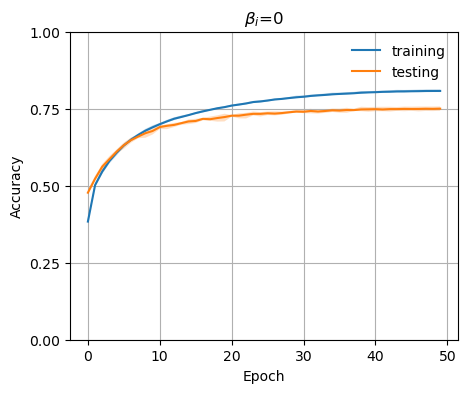

In [7]:

for ifbsc in range(len(fbsc_range)):
    testacctt = np.max(res[ifbsc,:,2,:], axis= -1)

    trainacctt = np.max(res[ifbsc,:,1,:], axis= -1)

    print(f'\t_'
        f"train: {np.mean(trainacctt) * 100:.2f}%+-{np.std(trainacctt, ddof=1)*100:.2f}% ({np.min(trainacctt) * 100:.2f}% {np.max(trainacctt) * 100:.2f}%)"
        f"\t test: {np.mean(testacctt) * 100:.2f}%+-{np.std(testacctt, ddof=1)*100:.2f}% ({np.min(testacctt) * 100:.2f}% {np.max(testacctt) * 100:.2f}%)\n")

for ifbsc in range(len(fbsc_range)):
    plt.figure(figsize=(5, 4))
    tt = res[ifbsc,:,1,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'training')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    tt = res[ifbsc,:,2,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'testing')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    if np.min(tt)<0.8:
        plt.ylim([0.0, 1.0])
        plt.yticks(np.arange(0.0,1.01,0.25))
    else:
        plt.ylim([0.9, 1.0])
        plt.yticks(np.arange(0.9,1.01,0.02))
    plt.grid()
    plt.title(r'$\beta_i$'+f"={fbsc_range[ifbsc]}")
    plt.xlabel(f'Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False)

    current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(f'Current Time: {current_time}')
    plt.savefig(res_path /f"aEP_cnn_MNIST_maxacc{np.max(tt)}-fbsc{fbsc_range[ifbsc]}-{current_time}.svg", format="svg")


### EP conv without weak feedback

In [8]:

num_epochs = 50
multest =1 #5
fbsc_range = [0] # 0.01, 0.1, 1
res = np.zeros((len(fbsc_range),multest,3,num_epochs))
for ifbsc in range(len(fbsc_range)):
# for ilr, lr in enumerate([2.5e-4]):
#     for iwd, wd in enumerate( [2.5e-4]):
    for imul in range(multest):
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{ifbsc} start at {current_time_tmp}")

        model = aEP_CNN(fbsc=1, nudge=0.25,  T=300, K=10, chl=[32,64,128])
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=2.5e-4, weight_decay=2e-4) # 0.5 2.5 2e-4 5e-4
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 
                                         T_max=num_epochs,  
                                         eta_min=1e-6) 

        for epoch in range(num_epochs):
            total_loss = 0
            correct = 0
            total = 0

            random.shuffle(train_loader_gpu)
            with tqdm(total=len(train_loader_gpu), desc=f"Epoch {epoch + 1}/{num_epochs}:", unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                for batch_idx, (data, target) in enumerate(train_loader_gpu):
                    optimizer.zero_grad()
                    # model.bw_symm()
                    preds, loss = model.ep_step(data, target)# eta=[0.015, 0.035, 0.15]
                    optimizer.step()
                    total_loss += loss

                    if batch_idx % 10 == 0: 
                        pbar.set_postfix({'loss': f'{total_loss/(batch_idx+1):.6f}'})  
                        pbar.update(10)

                    correct += (preds == target).sum().item()
                    total += target.size(0)
                        
            scheduler.step()
            
            acc = correct / total
            avg_loss = total_loss / len(train_loader_gpu)
            res[ifbsc,imul,0,epoch]=(avg_loss)
            res[ifbsc,imul,1,epoch]=(acc)

            # Test
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader_gpu:
                    preds = model.predict(data)
                    correct += (preds == target).sum().item()
                    total += target.size(0)
            test_acc = correct / total
            res[ifbsc,imul,2,epoch]=(test_acc)

            print(f"Epoch {epoch+1} Train Loss = {avg_loss:.4f}, Accuracy = {acc*100:.2f}%, Test Accuracy = {test_acc*100:.2f}%")
        
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{ifbsc}-{imul} end at {current_time_tmp}")
        
res_EP = res
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if fsave: 
    save_dict = {
        "res": res
}
np.savez_compressed(res_path / f"res_EP",  **save_dict)


0 start at 20250924-184501


Epoch 1/50::   0%|                                             | 0/391 [00:00<?, ?batch/s]

Epoch 1/50:: 400batch [02:28,  2.70batch/s, loss=2.134952]                                2.134952]


Epoch 1 Train Loss = 2.1350, Accuracy = 20.85%, Test Accuracy = 26.74%


Epoch 2/50:: 400batch [02:24,  2.77batch/s, loss=2.003887]                                2.003887]


Epoch 2 Train Loss = 2.0039, Accuracy = 26.87%, Test Accuracy = 30.79%


Epoch 3/50:: 400batch [02:24,  2.78batch/s, loss=1.928690]                                1.928690]


Epoch 3 Train Loss = 1.9287, Accuracy = 29.92%, Test Accuracy = 32.89%


Epoch 4/50:: 400batch [02:23,  2.78batch/s, loss=1.896201]                                1.896201]


Epoch 4 Train Loss = 1.8962, Accuracy = 31.46%, Test Accuracy = 35.24%


Epoch 5/50:: 400batch [02:25,  2.76batch/s, loss=1.842575]                                1.842575]


Epoch 5 Train Loss = 1.8426, Accuracy = 33.71%, Test Accuracy = 34.78%


Epoch 6/50:: 400batch [02:26,  2.72batch/s, loss=1.820466]                                1.820466]


Epoch 6 Train Loss = 1.8205, Accuracy = 34.70%, Test Accuracy = 32.77%


Epoch 7/50:: 400batch [02:26,  2.73batch/s, loss=1.822247]                                1.822247]


Epoch 7 Train Loss = 1.8222, Accuracy = 34.77%, Test Accuracy = 33.80%


Epoch 8/50:: 400batch [02:27,  2.71batch/s, loss=1.861275]                                1.861275]


Epoch 8 Train Loss = 1.8613, Accuracy = 33.30%, Test Accuracy = 34.06%


Epoch 9/50:: 400batch [02:27,  2.71batch/s, loss=1.830999]                                1.830999]


Epoch 9 Train Loss = 1.8310, Accuracy = 34.79%, Test Accuracy = 37.31%


Epoch 10/50:: 400batch [02:26,  2.73batch/s, loss=1.780540]                               1.780540]


Epoch 10 Train Loss = 1.7805, Accuracy = 36.40%, Test Accuracy = 36.91%


Epoch 11/50:: 400batch [02:28,  2.70batch/s, loss=1.748845]                               1.748845]


Epoch 11 Train Loss = 1.7488, Accuracy = 37.71%, Test Accuracy = 37.05%


Epoch 12/50:: 400batch [02:27,  2.72batch/s, loss=1.732577]                               1.732577]


Epoch 12 Train Loss = 1.7326, Accuracy = 37.98%, Test Accuracy = 39.00%


Epoch 13/50:: 400batch [02:26,  2.73batch/s, loss=1.721179]                               1.721179]


Epoch 13 Train Loss = 1.7212, Accuracy = 38.25%, Test Accuracy = 36.77%


Epoch 14/50:: 400batch [02:27,  2.71batch/s, loss=1.725773]                               1.725773]


Epoch 14 Train Loss = 1.7258, Accuracy = 38.51%, Test Accuracy = 39.37%


Epoch 15/50:: 400batch [02:27,  2.72batch/s, loss=1.725786]                               1.725786]


Epoch 15 Train Loss = 1.7258, Accuracy = 38.79%, Test Accuracy = 39.82%


Epoch 16/50:: 400batch [02:27,  2.71batch/s, loss=1.714414]                               1.714414]


Epoch 16 Train Loss = 1.7144, Accuracy = 38.87%, Test Accuracy = 29.77%


Epoch 17/50:: 400batch [02:27,  2.71batch/s, loss=1.851986]                               1.851986]


Epoch 17 Train Loss = 1.8520, Accuracy = 33.52%, Test Accuracy = 36.54%


Epoch 18/50:: 400batch [02:28,  2.70batch/s, loss=1.750188]                               1.750188]


Epoch 18 Train Loss = 1.7502, Accuracy = 37.44%, Test Accuracy = 40.03%


Epoch 19/50:: 400batch [02:26,  2.72batch/s, loss=1.673918]                               1.673918]


Epoch 19 Train Loss = 1.6739, Accuracy = 40.32%, Test Accuracy = 39.73%


Epoch 20/50:: 400batch [02:27,  2.71batch/s, loss=1.656983]                               1.656983]


Epoch 20 Train Loss = 1.6570, Accuracy = 40.68%, Test Accuracy = 42.02%


Epoch 21/50:: 400batch [02:26,  2.72batch/s, loss=1.637421]                               1.637421]


Epoch 21 Train Loss = 1.6374, Accuracy = 41.73%, Test Accuracy = 41.56%


Epoch 22/50:: 400batch [02:28,  2.70batch/s, loss=1.616482]                               1.616482]


Epoch 22 Train Loss = 1.6165, Accuracy = 42.48%, Test Accuracy = 43.77%


Epoch 23/50:: 400batch [02:27,  2.71batch/s, loss=1.601470]                               1.601470]


Epoch 23 Train Loss = 1.6015, Accuracy = 42.84%, Test Accuracy = 42.11%


Epoch 24/50:: 400batch [02:27,  2.71batch/s, loss=1.598857]                               1.598857]


Epoch 24 Train Loss = 1.5989, Accuracy = 42.95%, Test Accuracy = 44.41%


Epoch 25/50:: 400batch [02:28,  2.70batch/s, loss=1.596270]                               1.596270]


Epoch 25 Train Loss = 1.5963, Accuracy = 42.99%, Test Accuracy = 38.70%


Epoch 26/50:: 400batch [02:27,  2.70batch/s, loss=1.716626]                               1.716626]


Epoch 26 Train Loss = 1.7166, Accuracy = 38.74%, Test Accuracy = 37.15%


Epoch 27/50:: 400batch [02:27,  2.71batch/s, loss=1.748955]                               1.748955]


Epoch 27 Train Loss = 1.7490, Accuracy = 37.50%, Test Accuracy = 37.58%


Epoch 28/50:: 400batch [02:27,  2.72batch/s, loss=1.779641]                               1.779641]


Epoch 28 Train Loss = 1.7796, Accuracy = 36.26%, Test Accuracy = 38.38%


Epoch 29/50:: 400batch [02:28,  2.70batch/s, loss=1.705829]                               1.705829]


Epoch 29 Train Loss = 1.7058, Accuracy = 38.76%, Test Accuracy = 39.05%


Epoch 30/50:: 400batch [02:28,  2.70batch/s, loss=1.671272]                               1.671272]


Epoch 30 Train Loss = 1.6713, Accuracy = 40.02%, Test Accuracy = 41.83%


Epoch 31/50:: 400batch [02:27,  2.72batch/s, loss=1.644302]                               1.644302]


Epoch 31 Train Loss = 1.6443, Accuracy = 41.32%, Test Accuracy = 41.45%


Epoch 32/50:: 400batch [02:27,  2.71batch/s, loss=1.625586]                               1.625586]


Epoch 32 Train Loss = 1.6256, Accuracy = 41.80%, Test Accuracy = 43.52%


Epoch 33/50:: 400batch [02:28,  2.69batch/s, loss=1.577220]                               1.577220]


Epoch 33 Train Loss = 1.5772, Accuracy = 43.59%, Test Accuracy = 43.37%


Epoch 34/50:: 400batch [02:28,  2.70batch/s, loss=1.596005]                               1.596005]


Epoch 34 Train Loss = 1.5960, Accuracy = 43.01%, Test Accuracy = 43.02%


Epoch 35/50:: 400batch [02:29,  2.68batch/s, loss=1.637744]                               1.637744]


Epoch 35 Train Loss = 1.6377, Accuracy = 41.36%, Test Accuracy = 40.48%


Epoch 36/50:: 400batch [02:28,  2.69batch/s, loss=1.687469]                               1.687469]


Epoch 36 Train Loss = 1.6875, Accuracy = 39.59%, Test Accuracy = 39.37%


Epoch 37/50:: 400batch [02:28,  2.69batch/s, loss=1.693694]                               1.693694]


Epoch 37 Train Loss = 1.6937, Accuracy = 39.76%, Test Accuracy = 39.45%


Epoch 38/50:: 400batch [02:28,  2.69batch/s, loss=1.678013]                               1.678013]


Epoch 38 Train Loss = 1.6780, Accuracy = 40.32%, Test Accuracy = 41.08%


Epoch 39/50:: 400batch [02:28,  2.70batch/s, loss=1.657659]                               1.657659]


Epoch 39 Train Loss = 1.6577, Accuracy = 41.28%, Test Accuracy = 41.92%


Epoch 40/50:: 400batch [02:38,  2.53batch/s, loss=1.645165]                               1.645165]


Epoch 40 Train Loss = 1.6452, Accuracy = 42.01%, Test Accuracy = 42.11%


Epoch 41/50:: 400batch [02:58,  2.25batch/s, loss=1.639345]                               1.639345]


Epoch 41 Train Loss = 1.6393, Accuracy = 42.40%, Test Accuracy = 41.85%


Epoch 42/50:: 400batch [02:53,  2.31batch/s, loss=1.636588]                               1.636588]


Epoch 42 Train Loss = 1.6366, Accuracy = 42.29%, Test Accuracy = 42.31%


Epoch 43/50:: 400batch [02:28,  2.69batch/s, loss=1.635983]                               1.635983]


Epoch 43 Train Loss = 1.6360, Accuracy = 42.29%, Test Accuracy = 42.37%


Epoch 44/50:: 400batch [02:27,  2.71batch/s, loss=1.634056]                               1.634056]


Epoch 44 Train Loss = 1.6341, Accuracy = 42.29%, Test Accuracy = 42.54%


Epoch 45/50:: 400batch [02:27,  2.71batch/s, loss=1.632782]                               1.632782]


Epoch 45 Train Loss = 1.6328, Accuracy = 42.18%, Test Accuracy = 42.55%


Epoch 46/50:: 400batch [02:28,  2.69batch/s, loss=1.639025]                               1.639025]


Epoch 46 Train Loss = 1.6390, Accuracy = 42.01%, Test Accuracy = 42.95%


Epoch 47/50:: 400batch [02:29,  2.68batch/s, loss=1.642786]                               1.642786]


Epoch 47 Train Loss = 1.6428, Accuracy = 42.32%, Test Accuracy = 42.98%


Epoch 48/50:: 400batch [02:27,  2.70batch/s, loss=1.645238]                               1.645238]


Epoch 48 Train Loss = 1.6452, Accuracy = 42.11%, Test Accuracy = 42.76%


Epoch 49/50:: 400batch [02:28,  2.69batch/s, loss=1.644957]                               1.644957]


Epoch 49 Train Loss = 1.6450, Accuracy = 42.28%, Test Accuracy = 42.53%


Epoch 50/50:: 400batch [02:28,  2.69batch/s, loss=1.644595]                               1.644595]


Epoch 50 Train Loss = 1.6446, Accuracy = 42.16%, Test Accuracy = 42.61%
0-0 end at 20250924-210844


	_train: 43.59%+-nan% (43.59% 43.59%)	 test: 44.41%+-nan% (44.41% 44.41%)

Current Time: 20250924-210844
Current Time: 20250924-210844


c:\Users\op1\anaconda3\envs\torchgpu\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\op1\anaconda3\envs\torchgpu\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


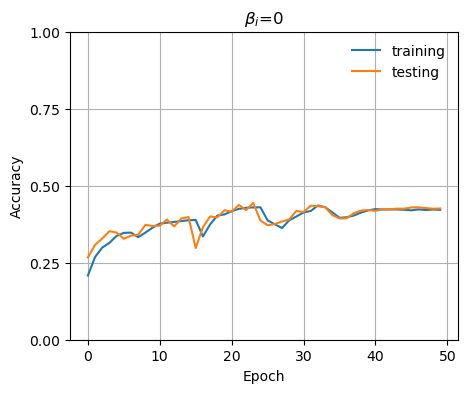

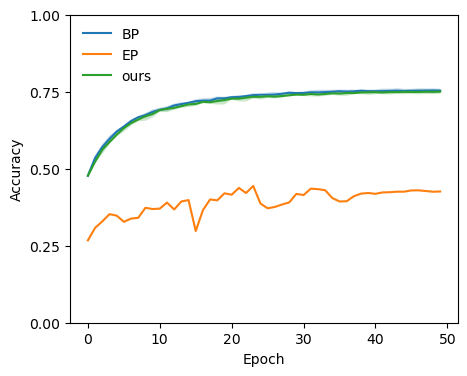

In [9]:

     
for ifbsc in range(len(fbsc_range)):
    testacctt = np.max(res[ifbsc,:,2,:], axis= -1)

    trainacctt = np.max(res[ifbsc,:,1,:], axis= -1)

    print(f'\t_'
        f"train: {np.mean(trainacctt) * 100:.2f}%+-{np.std(trainacctt, ddof=1)*100:.2f}% ({np.min(trainacctt) * 100:.2f}% {np.max(trainacctt) * 100:.2f}%)"
        f"\t test: {np.mean(testacctt) * 100:.2f}%+-{np.std(testacctt, ddof=1)*100:.2f}% ({np.min(testacctt) * 100:.2f}% {np.max(testacctt) * 100:.2f}%)\n")

for ifbsc in range(len(fbsc_range)):
    plt.figure(figsize=(5, 4))
    tt = res[ifbsc,:,1,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'training')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    tt = res[ifbsc,:,2,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'testing')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    if np.min(tt)<0.8:
        plt.ylim([0.0, 1.0])
        plt.yticks(np.arange(0.0,1.01,0.25))
    else:
        plt.ylim([0.9, 1.0])
        plt.yticks(np.arange(0.9,1.01,0.02))
    plt.grid()
    plt.title(r'$\beta_i$'+f"={fbsc_range[ifbsc]}")
    plt.xlabel(f'Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False)

    current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(f'Current Time: {current_time}')
    plt.savefig(res_path /f"EP_cnn_MNIST_maxacc{np.max(tt)}-fbsc{fbsc_range[ifbsc]}-{current_time}.svg", format="svg")


    plt.figure(figsize=(5, 4))
for labels, res in zip(['BP', 'EP', 'ours'], [res_BP, res_EP, res_aEP]):
    ifbsc = 0
    # tt = res[ifbsc,:,1,:]
    # plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'training')  #  plot
    # plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    tt = res[ifbsc,:,2,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=labels)  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    if np.min(tt)<0.8:
        plt.ylim([0.0, 1.0])
        plt.yticks(np.arange(0.0,1.01,0.25))
    else:
        plt.ylim([0.9, 1.0])
        plt.yticks(np.arange(0.9,1.01,0.02))
    # plt.grid()
    # plt.title(r'$\beta_i$'+f"={fbsc_range[ifbsc]}")
    plt.xlabel(f'Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False)

current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(f'Current Time: {current_time}')
plt.savefig(res_path /f"All_cnn_MNIST_maxacc{np.max(tt)}-fbsc{fbsc_range[ifbsc]}-{current_time}.svg", format="svg")